# Dev / Library

In [1]:
!pip install coclust

  Running setup.py bdist_wheel for coclust ... - done
  Stored in directory: /home/jovyan/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


In [2]:
import os
report_project = os.environ['REPORT_PROJECT']

In [3]:
import numpy as np

In [4]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import random

In [5]:
def save_fig(name):
    pass

## Import data from spoon.

In [6]:
import json
def open_json(file_path):
    datastore = {}
    with open(file_path, 'r') as f:
        datastore = json.load(f)
    return datastore

A fonction to get the name of a library according to its definition and the depth.

> 'java.util.ArrayList', depth=2 -> 'java.util'



In [7]:
def import_to_name(library_import, depth):
    return '.'.join(library_import.split('.')[:depth])

Define the mapping of imports to an ids.

In [8]:
def define_mapping(libraries_set, depth): # TODO : Option to keep tree structure
    A = set(sorted([import_to_name(library_import, depth) for library_import in libraries_set]) + ['UNK'])
    length = len(A)
    map_dict = dict(zip(A, range(length)))
    def mapping(import_value):
        name = import_to_name(import_value, depth)
        if name not in A:
            name = 'UNK'
        return map_dict[name]
    return mapping, A, length

In [9]:
# 2 more or less equal to the library level 
data = open_json(f'{report_project}_commits.json')
libraries_set = data['libraries_set']
commit_info = data['commit_info']
library_depth = 2
mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, library_depth)

Some basic vector operators

In [10]:
def v_sum(*v):
    return tuple([sum(e) for e in zip(*v)])

def z_k(n, *Ks):
    z_k = [0] * n
    for i in Ks:
        z_k[i] = 1
    return tuple(z_k)

Count for every commits the number of time a library was imported in all modified files.

In [11]:
import pandas as pd
data = []

duplicate_entries = (
    ('Tobias Ivarsson','tobias'),
    
)

duplicate_entries = dict([ (b,a) for (a,b) in duplicate_entries])
author_emails = {}

for sha, commit in list(commit_info.items()):
    author_name = commit['author']['name']
    if author_name in duplicate_entries:
        commit['author']['name'] = duplicate_entries[author_name]
    if commit['author']['email'] not in author_emails:
        author_emails[commit['author']['email']] = set()
    author_emails[commit['author']['email']] = author_emails[commit['author']['email']] | set([author_name])

for sha, commit in list(commit_info.items()):
    libraries = set()
    c = z_k(mapping_size)
    for file, file_info in commit['files_info'].items():
        file_libraries = set([ mapping(lib) for lib in file_info['imports'] ])
        libraries = libraries | file_libraries
        c = v_sum(c, z_k(mapping_size, *file_libraries))
    if len(libraries) > 0:
        author_name = commit['author']['name']
        data.append( [sha, author_name] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df = pd.DataFrame(data=data, columns=['sha', 'author', *mapping_elemnts])

In [12]:
{ key:item for key, item in author_emails.items() if len(item)>1}

{}

In [13]:
print(f'Total number of commit : {df.shape[0]}')
print(f'Made by {len(set(df.author))} unique contibutors')
print(f'Represented by {len(libraries_set)} imports')
print(f'mapped to {len(mapping_elemnts)} imports')

Total number of commit : 1993
Made by 8 unique contibutors
Represented by 1097 imports
mapped to 34 imports


Sum the commits by users.

**Then drop the contibutors who has modified 10 file or less. And the libraries imported less than once**

Finally sort the data in row and column by the number of modifications.

In [14]:
def group_duplicate_entry(df, *duplicate_entries):
    for entry1, entry2 in duplicate_entries:
        df.loc[entry1] = df.loc[entry1] + df.loc[entry2]
        df = df.drop(entry2)
    return df

agreg = df.groupby('author').sum()
agreg = agreg.loc[:,agreg.sum() > 1]
#agreg = agreg.loc[agreg.sum(axis=1) > 100]

#agreg = group_duplicate_entry(agreg, *duplicate_entries)

agreg_sorted = agreg.loc[agreg.sum(axis=1).sort_values(ascending=False).index]
agreg_sorted = agreg_sorted.loc[:,agreg_sorted.sum(axis=0).sort_values(ascending=False).index]

In [15]:
len(agreg.sum())

31

In [16]:
total_count = max(df.index)
f = {'index': ['mean', 'min', 'max', 'count']}
avg_contrib = pd.DataFrame(
    data=list(
        zip(
            df.loc[:,'author'],
            [ total_count - i for i in df.index])
        ),
    columns=['author', 'index']
).groupby('author').agg(f)
avg_contrib.head()

index                 
                        mean  min   max count
author                                       
Anders Nawroth   1403.568627  598  1819    51
Emil Eifrem       273.608108    0   948    74
Henrik Larsson    398.000000  398   398     1
Johan Svensson    746.275904   40  1989   830
Mattias Persson  1235.443843    6  1992   739

In [17]:
libraries_info = pd.DataFrame(data=[[0,0,0]] * len(mapping_elemnts), columns=['first', 'last', 'count'])
libraries_info.index = mapping_elemnts
for (index, row) in df.iloc[:,2:].iterrows():
    for lib, val in row.items():
        if val != 0:
            if libraries_info.loc[lib]['last'] == 0:
                libraries_info.loc[lib]['last'] = len(df) - index
            else:
                libraries_info.loc[lib]['first'] = len(df) - index
            libraries_info.loc[lib]['count'] += val

In [18]:
libraries_info['coef'] = np.exp(libraries_info.loc[:,'last'] / len(df) - 1) ** 3

In [19]:
libraries_info.head()

,first,last,count,coef
org.apache,1420,1990,213,0.995494
com.sun,1317,1319,3,0.362565
javax.transaction,1,1984,3390,0.986544
common.StandardGraphs,1310,1312,3,0.358765
jline.History,0,1192,1,0.299476


In [20]:
#fig, ax = plt.subplots(figsize=(14, 25), dpi=80)

#for i, row in libraries_info.sort_values('last').iterrows():
#    color = 'r'
#    ax.hlines(i, xmin=row['first'], xmax=row['last'], color=color)

#plt.show()

## Distance between libraries

[]

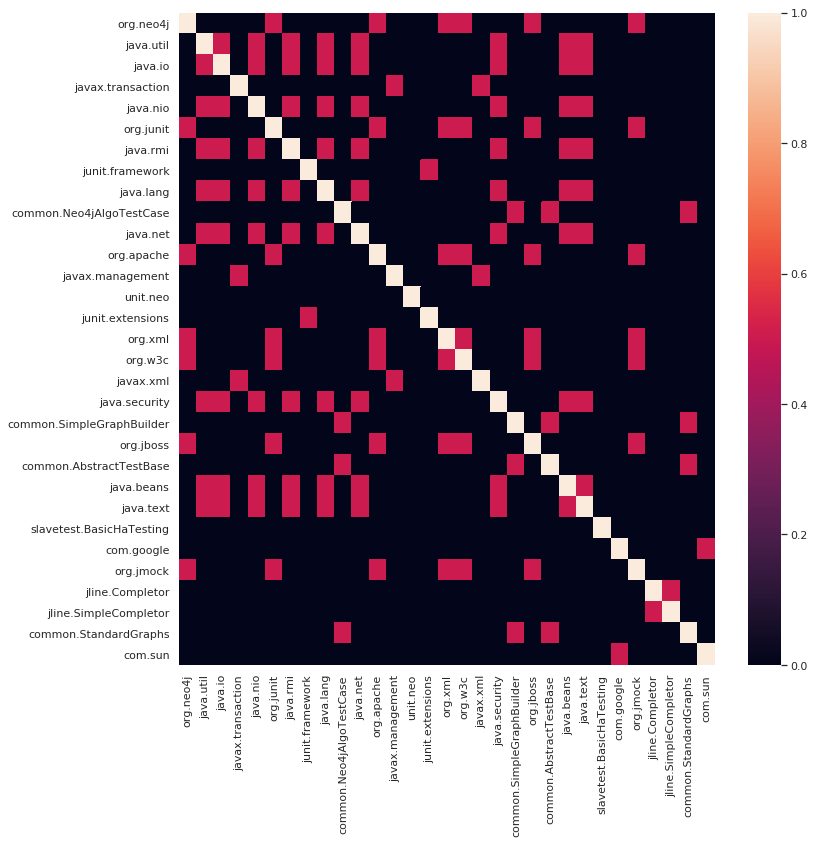

In [21]:
libraries = list(agreg_sorted.columns)
#libraries.sort()
librariy_trees = {}
def import_similarity(lib_A, lib_B):
    nodes_A = lib_A.split('.')
    nodes_B = lib_B.split('.')
    n = 0
    for node_A, node_B in zip(nodes_A, nodes_B):
        if node_A == node_B:
            n+=1
        else:
            break
    return n / library_depth

libraries_distance = pd.DataFrame(list(map(lambda x: list(map(lambda y: import_similarity(x,y), libraries)), libraries)), index=libraries, columns=libraries)
plt.figure(figsize=(12,12))
sns.heatmap(libraries_distance)
plt.plot()
#for library in libraries:
#    nodes = library.split('.')
#    tree = librariy_trees
#    for node in nodes:
#        if node not in tree:
#            tree[node] = {}
#        tree = tree[node]
#print(librariy_trees)

## Analysis

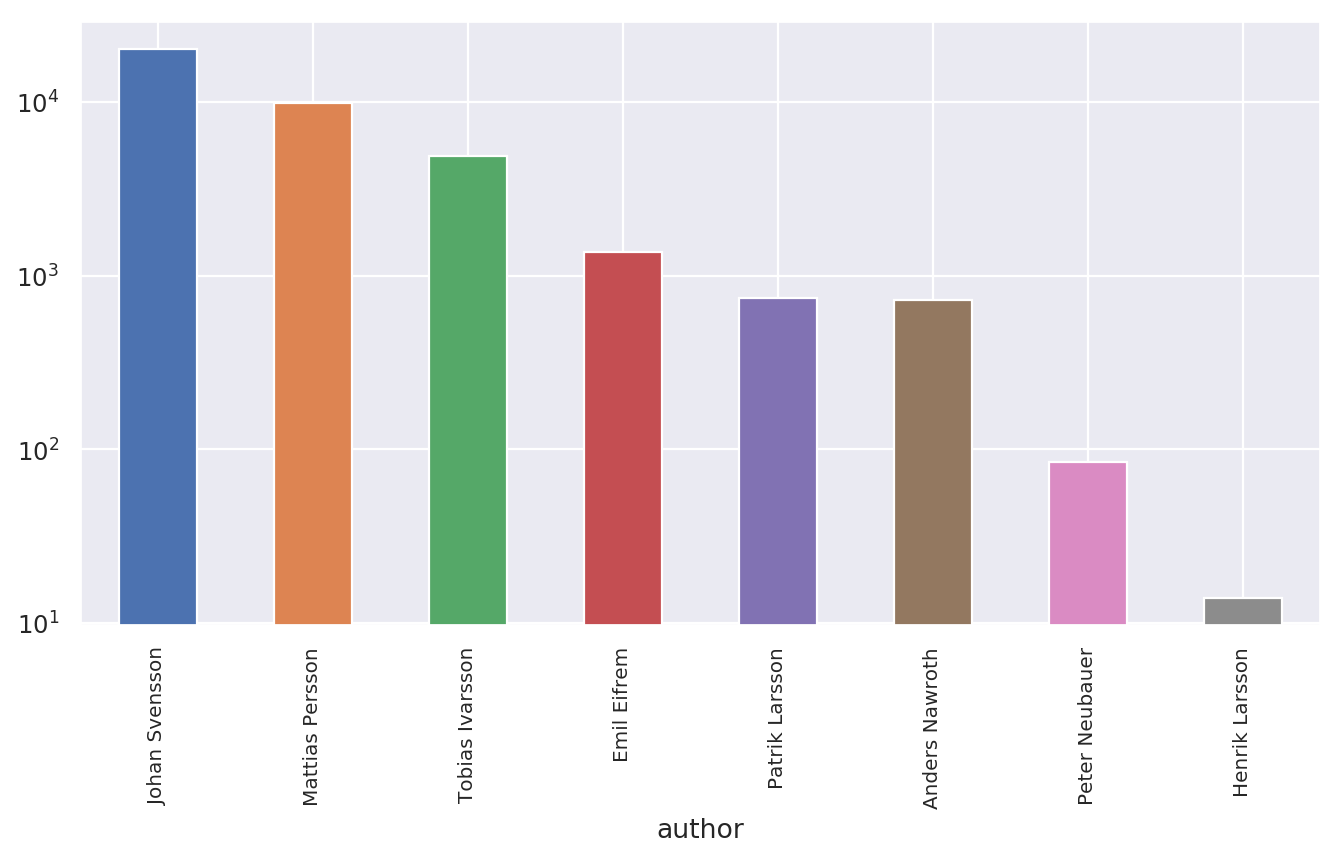

In [22]:
fig = plt.figure(figsize=(10, 5), dpi=160, facecolor='w', edgecolor='k')
number_of_contibs = agreg_sorted.sum(axis=1)
ax = number_of_contibs.plot.bar()
ax.set_yscale('log')
plt.xticks(range(len(list(number_of_contibs.index))), list(number_of_contibs.index), rotation=90, fontsize=9)
plt.show()

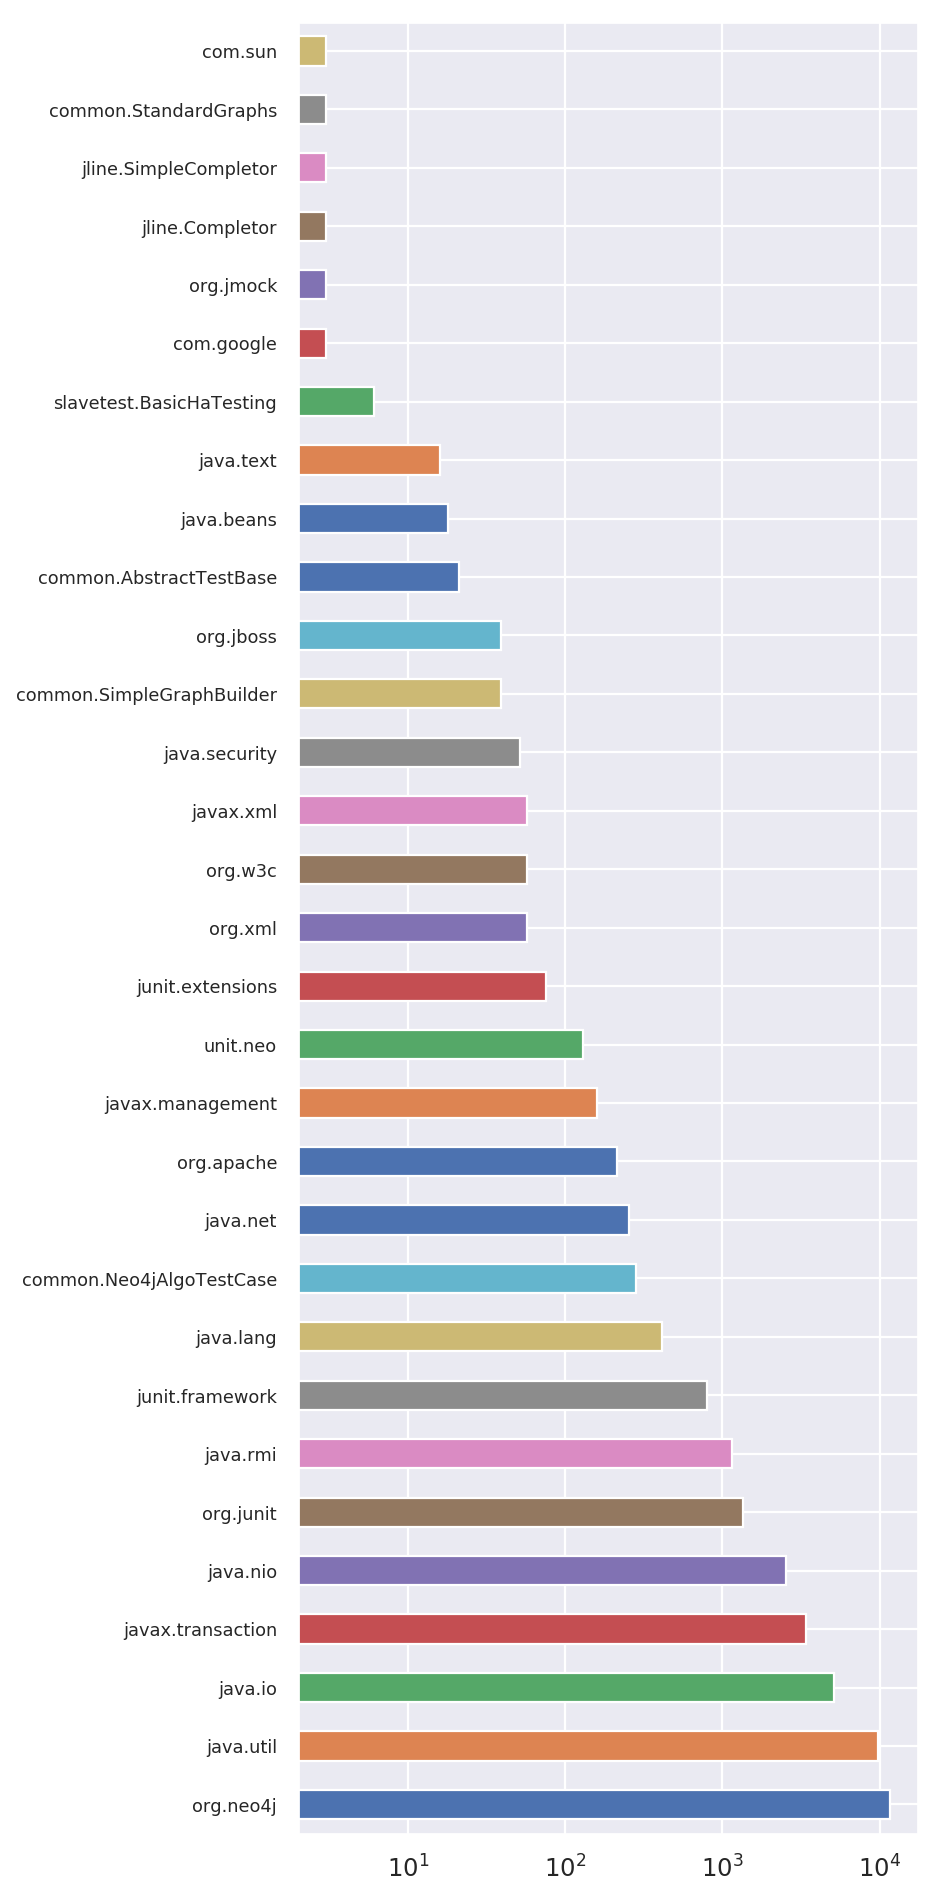

In [23]:
fig = plt.figure(figsize=(5, 15), dpi=160, facecolor='w', edgecolor='k')
number_of_imports = agreg_sorted.sum(axis=0)
ax = number_of_imports.plot.barh()
ax.set_xscale('log')
plt.yticks(range(len(list(number_of_imports.index))), list(number_of_imports.index), fontsize=8)
plt.show()

In [24]:
def plot_matrix(df, title, xlabel = '', ylabel='', log_scale=False, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize, dpi=160, facecolor='w', edgecolor='k')
    if log_scale:
        sns.heatmap(np.log10(df.add(1)))
    else:
        sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(list(df.columns))), list(df.columns), rotation=90, fontsize=9)
    plt.yticks(range(len(list(df.index))), list(df.index), fontsize=9)
    plt.title(title, fontsize=24)
    #plt.ylabel('some numbers')
    #plt.show()

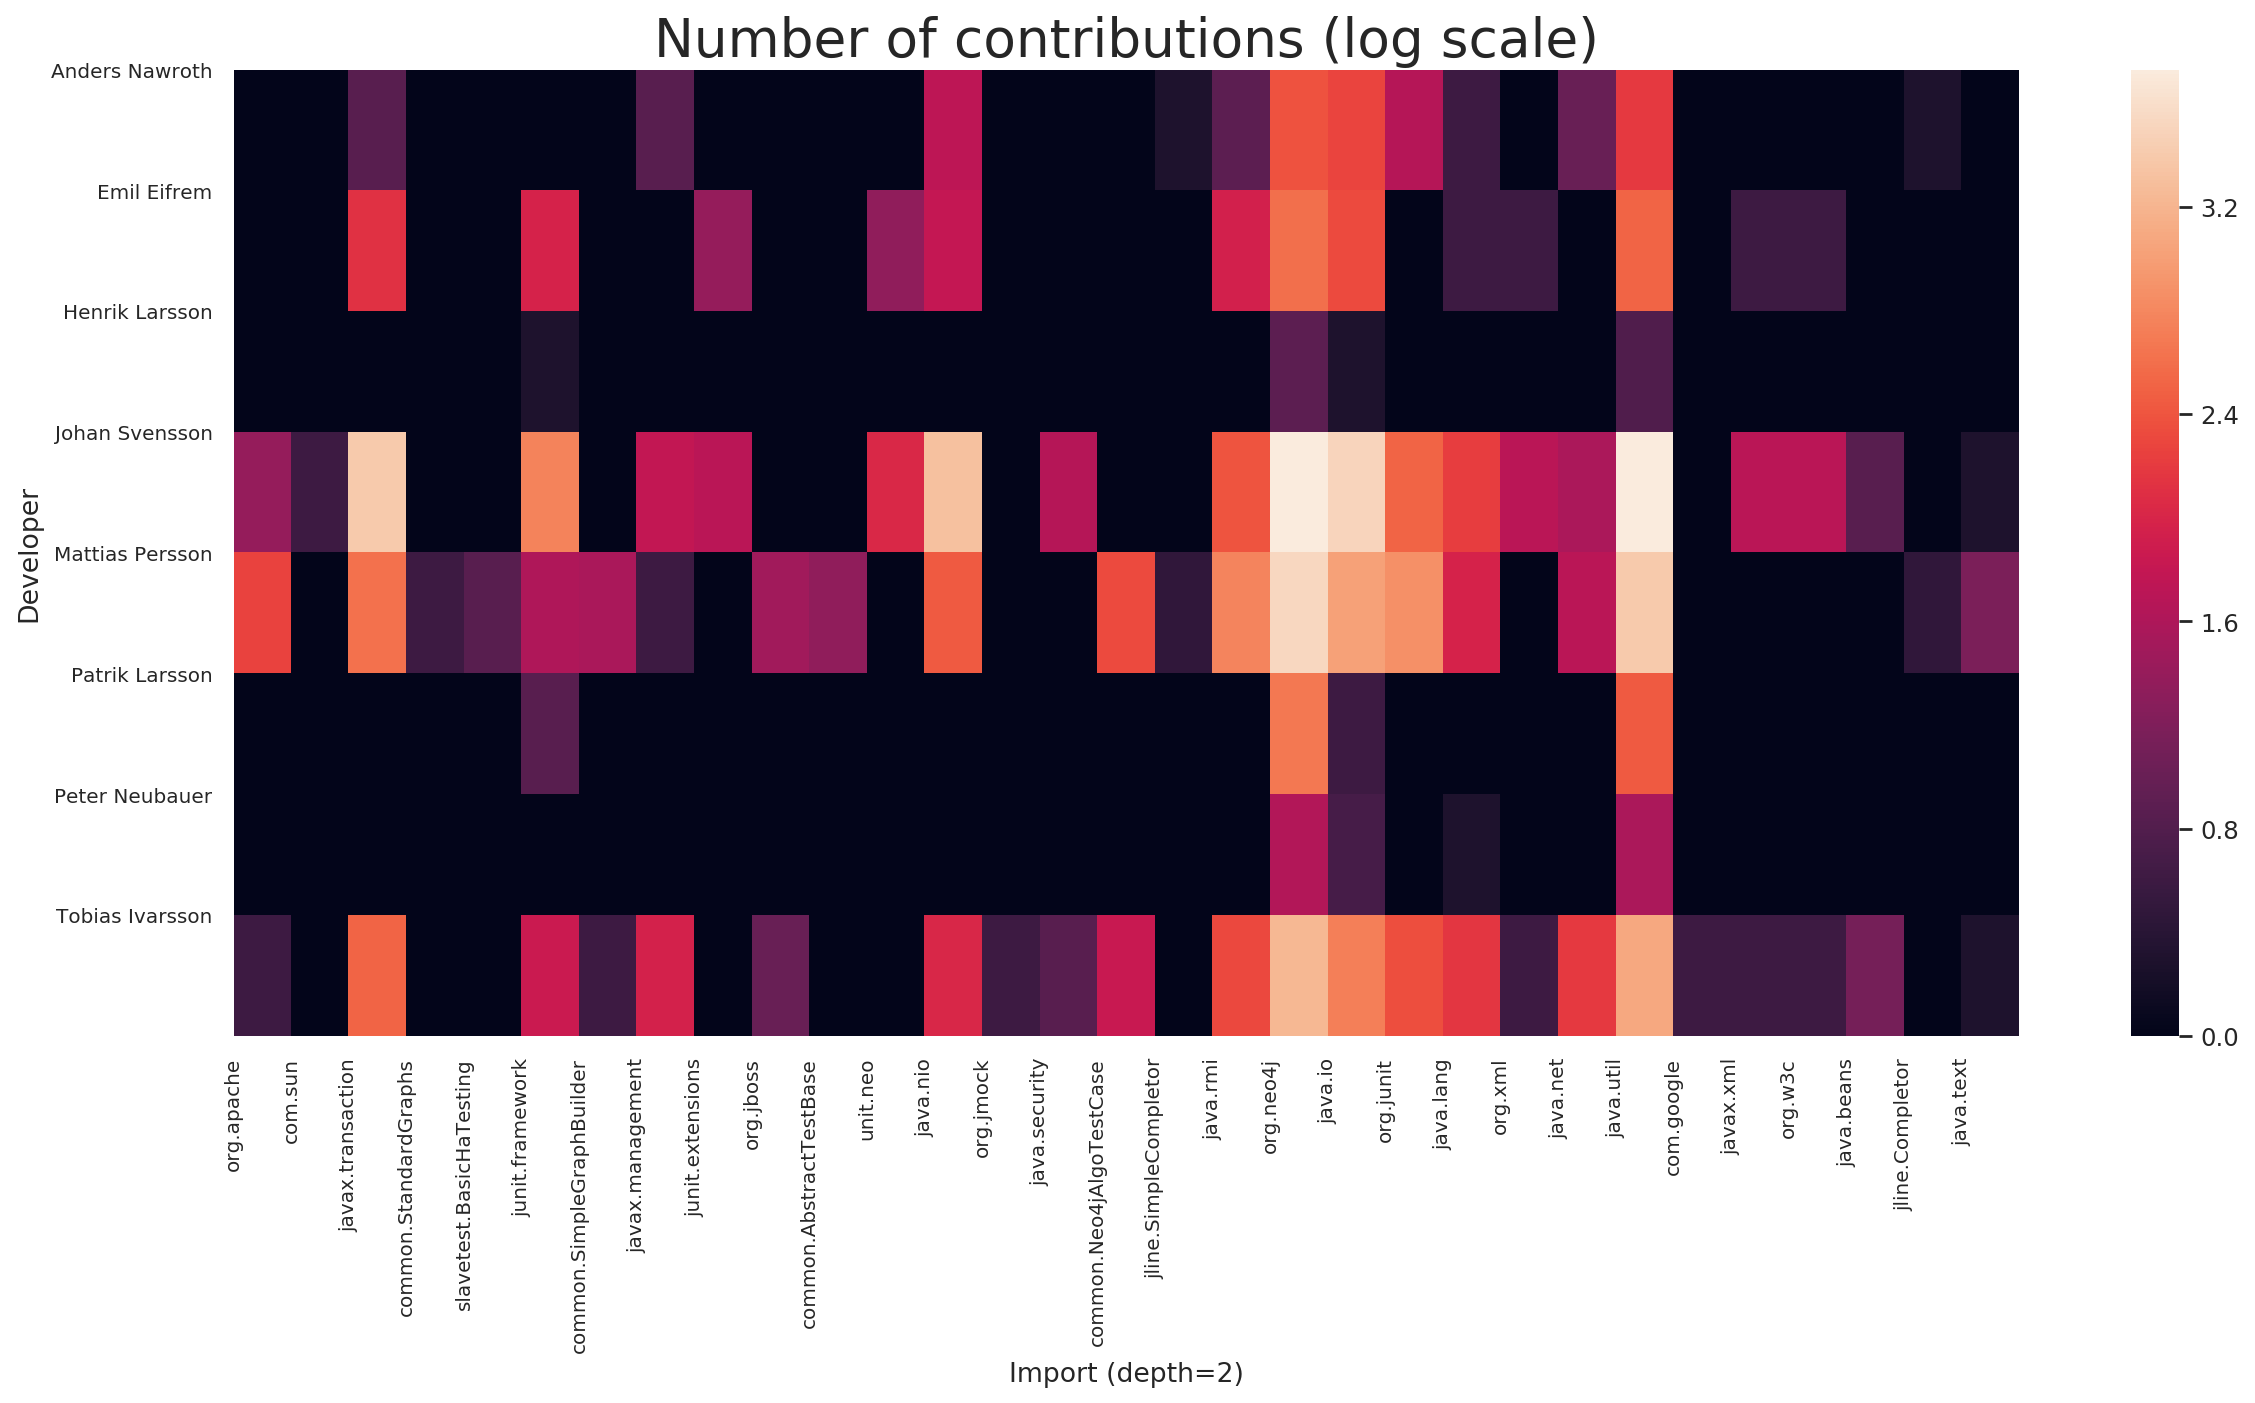

In [25]:
plot_matrix(agreg, 'Number of contributions (log scale)', xlabel='Import (depth=2)', ylabel='Developer', log_scale=True)
save_fig('author_lib_random')
plt.show()

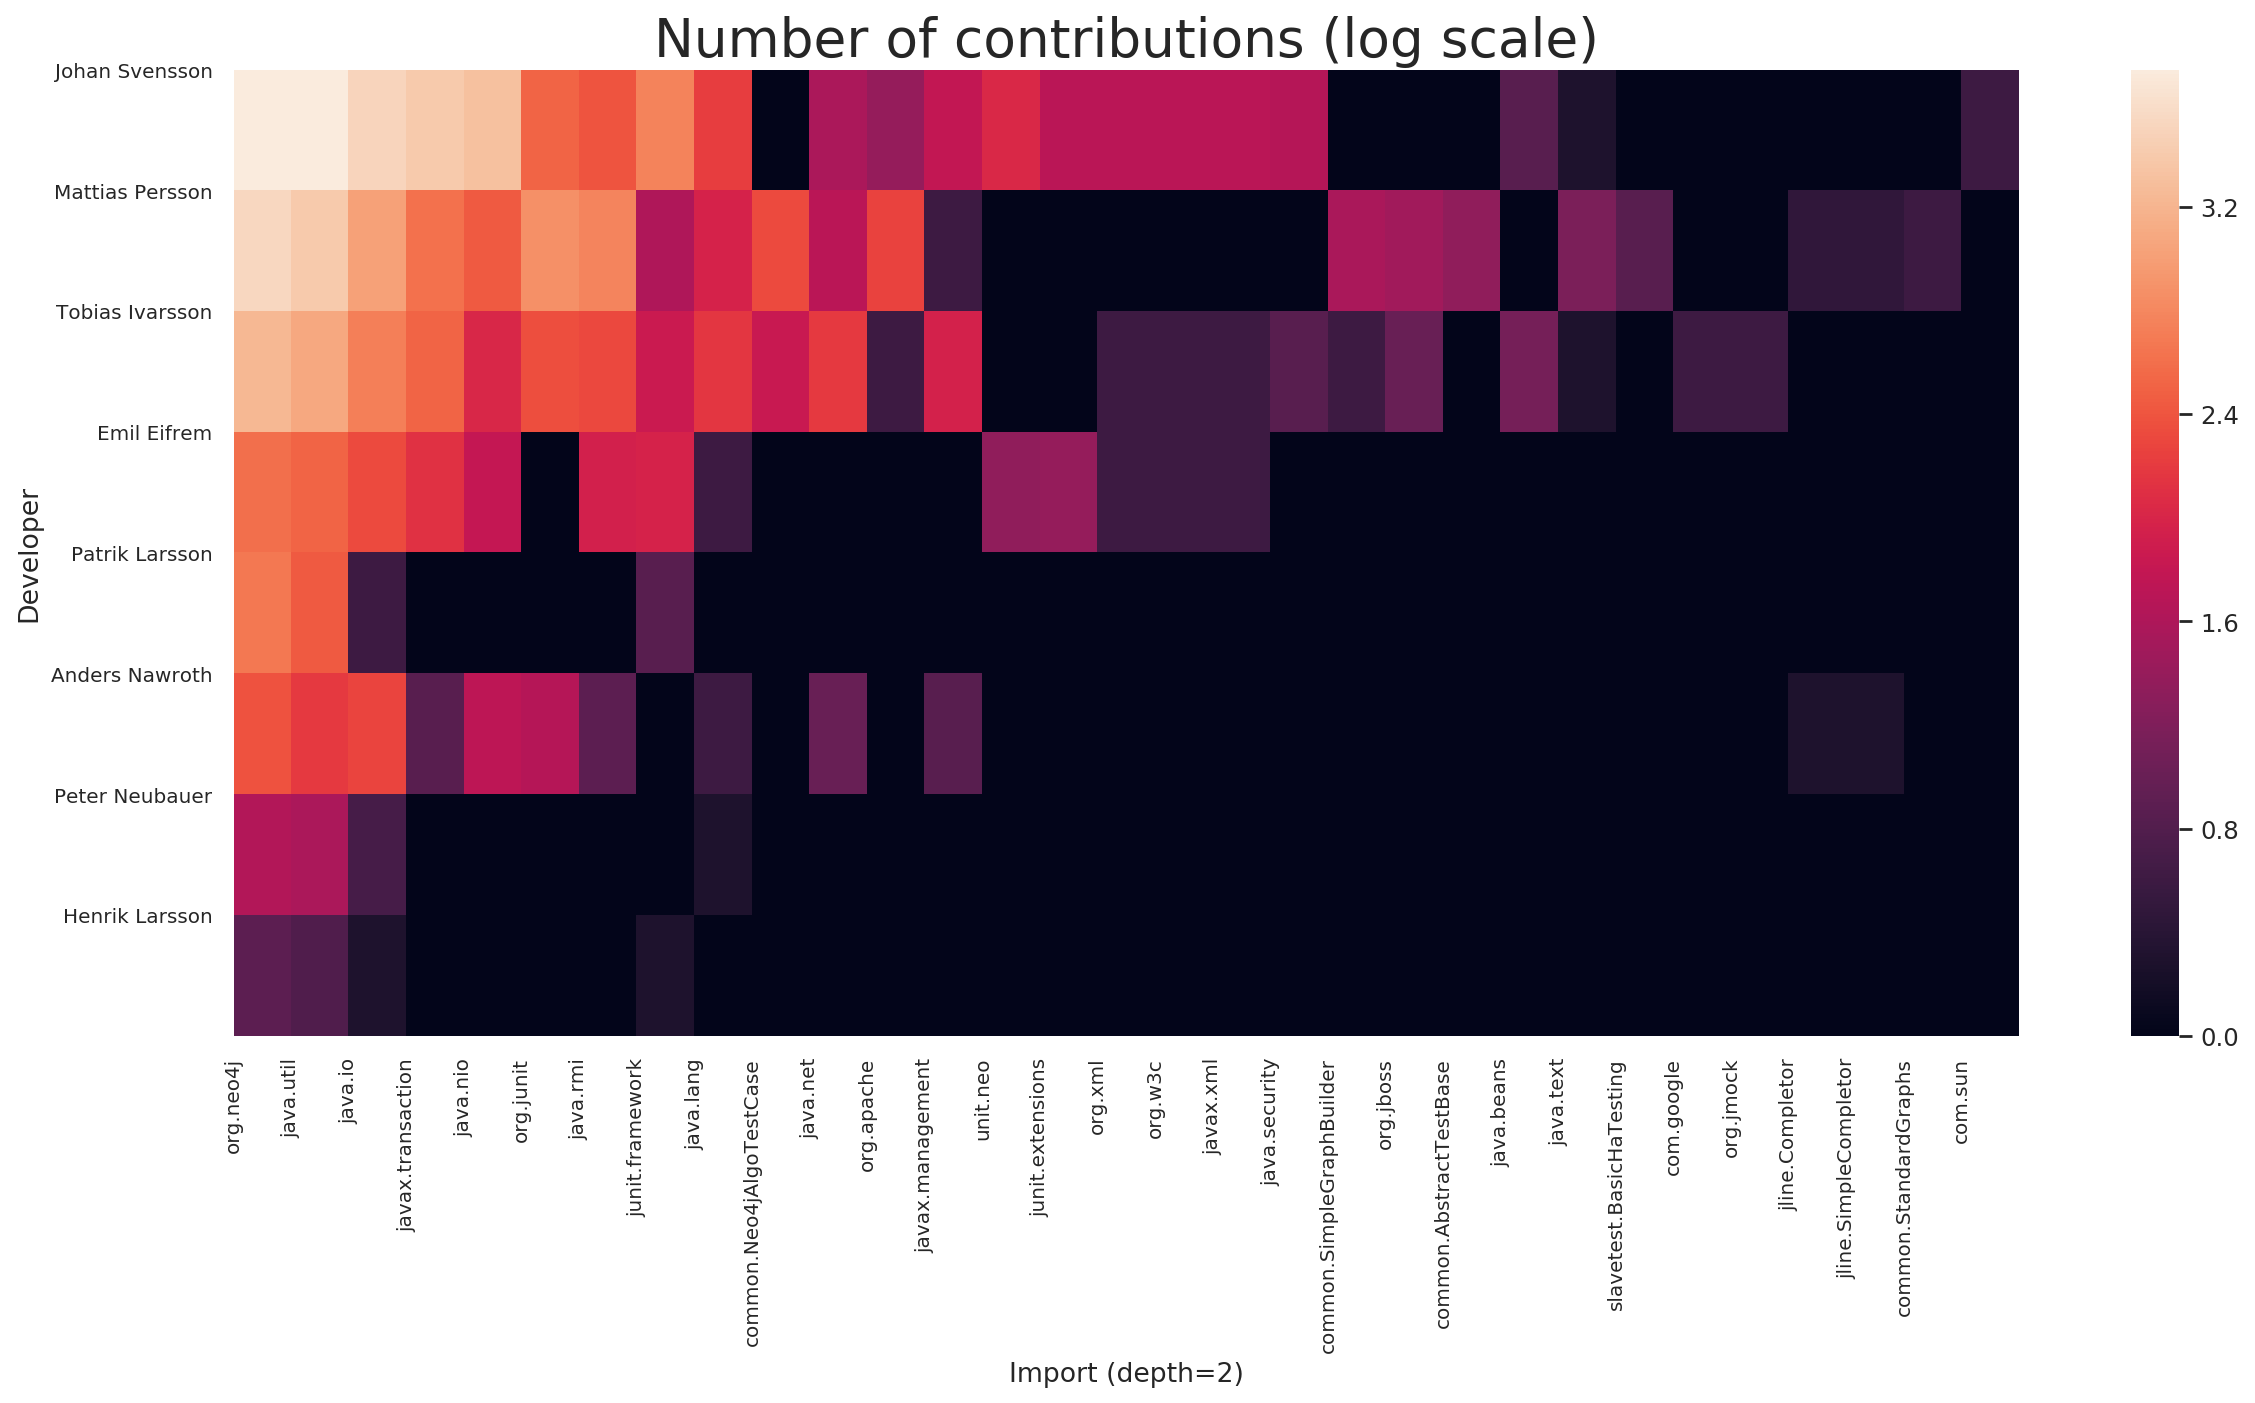

In [26]:
plot_matrix(agreg_sorted, 'Number of contributions (log scale)', xlabel='Import (depth=2)', ylabel='Developer', log_scale=True)
save_fig('author_lib_ordered')
plt.show()

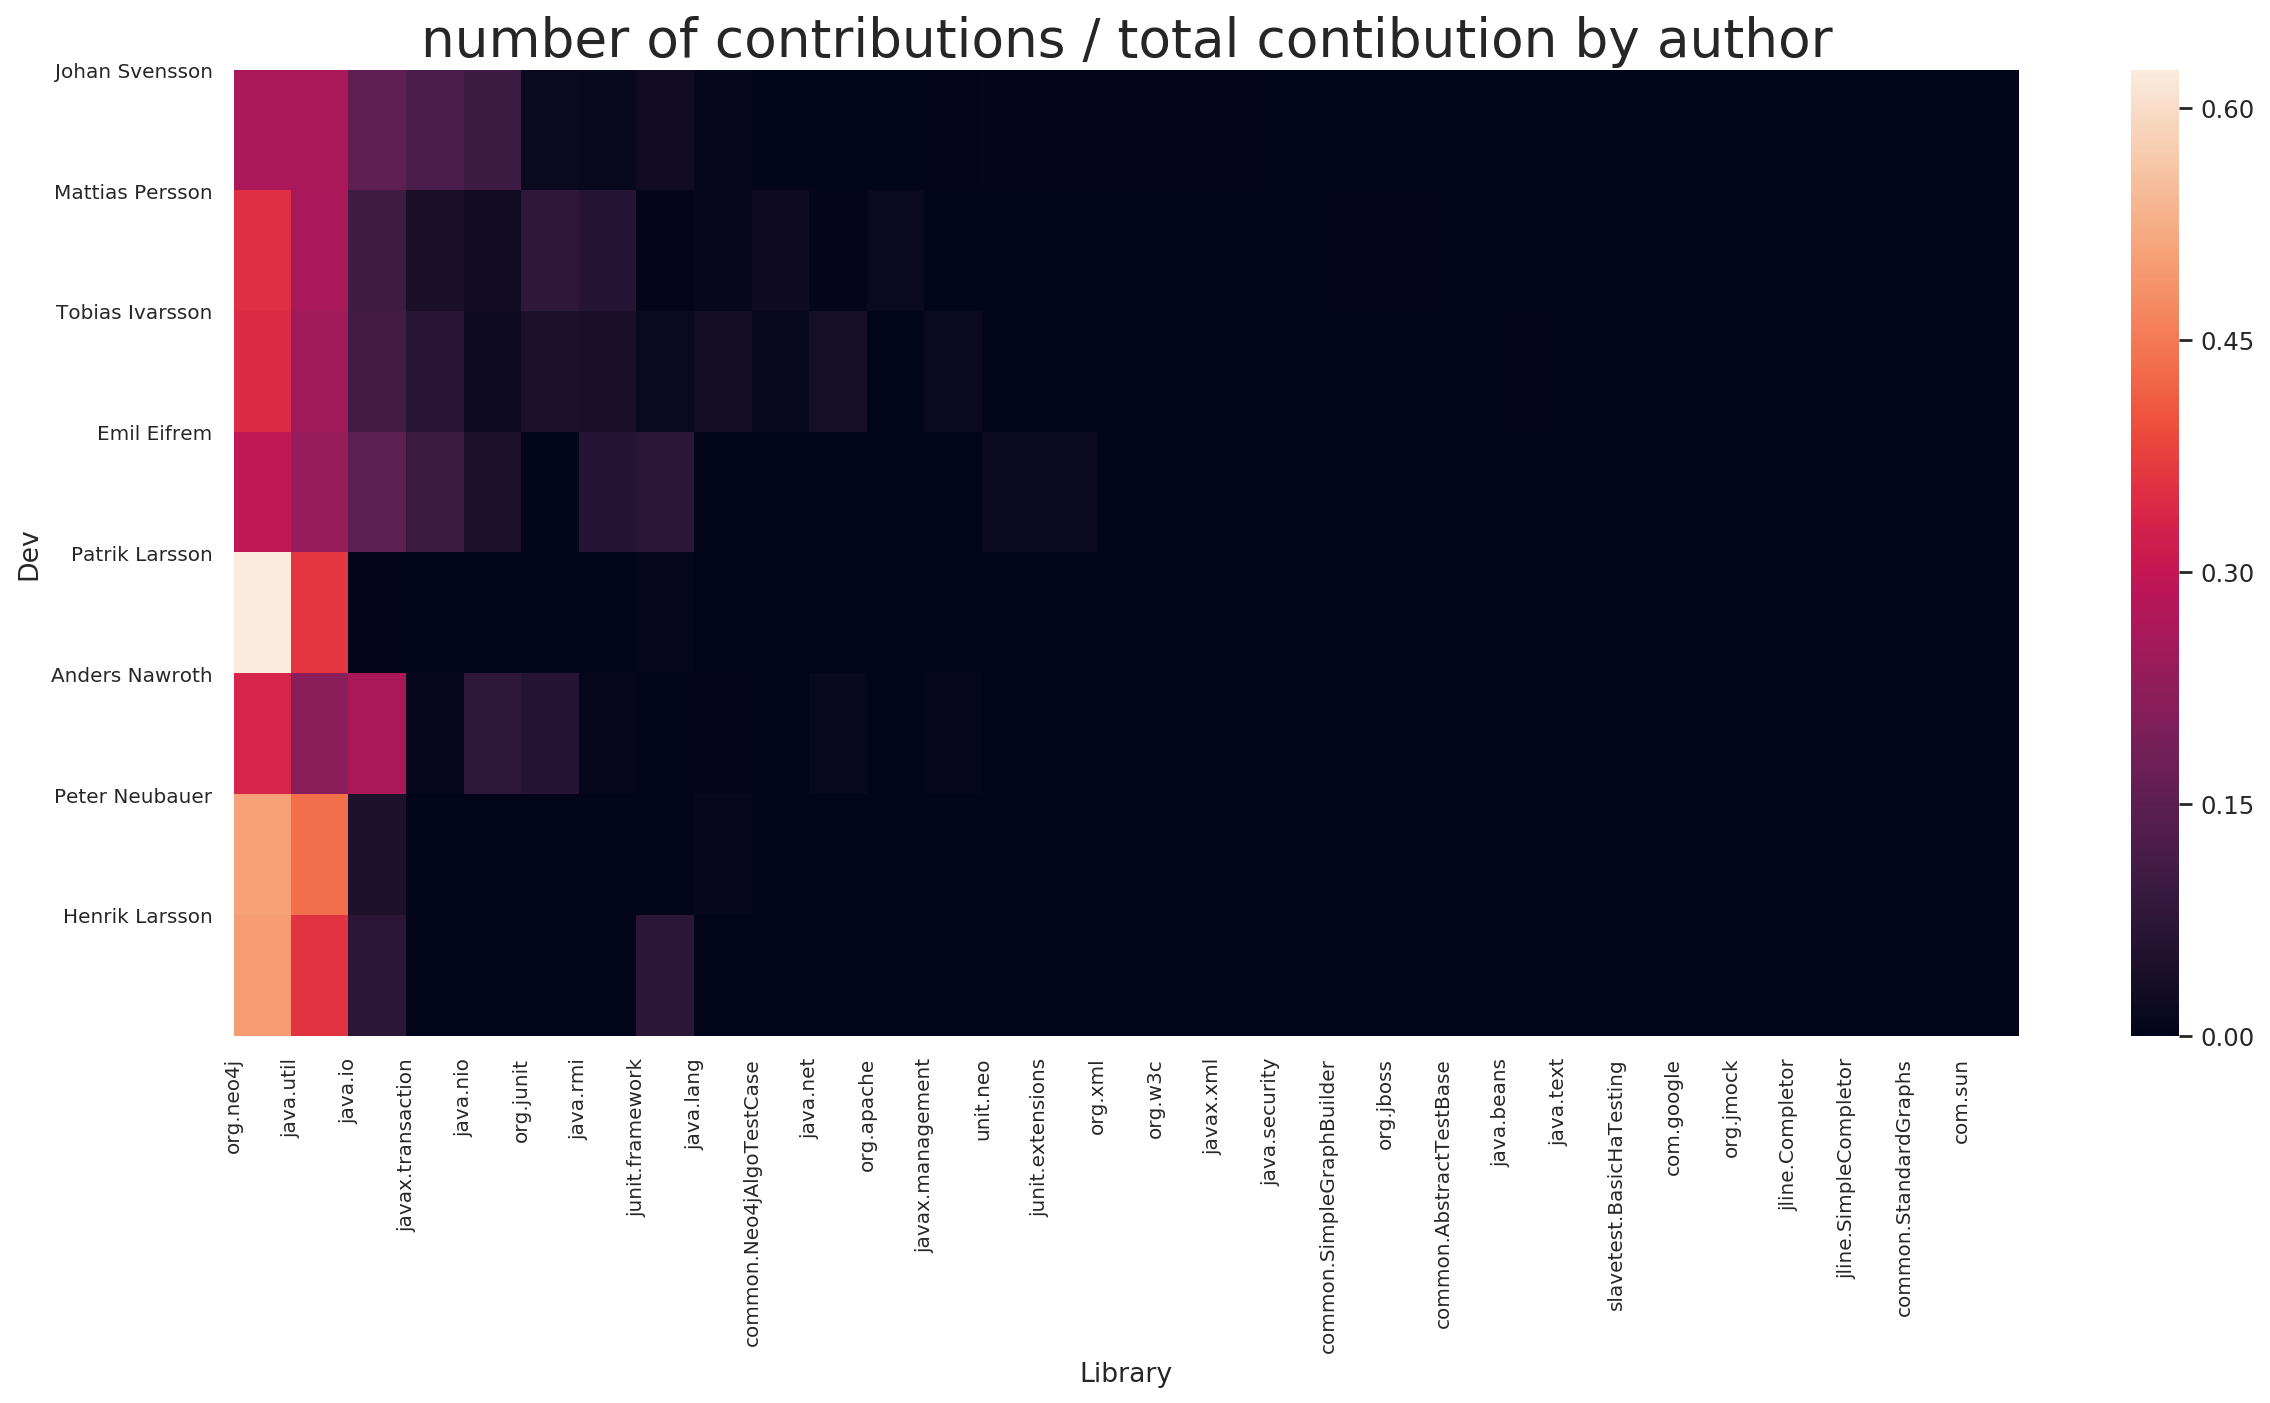

In [27]:
ratio_libcontrib_totcontrib = agreg_sorted.div(agreg_sorted.sum(axis=1), axis = 0)
plot_matrix(ratio_libcontrib_totcontrib, 'number of contributions / total contibution by author', xlabel='Library', ylabel='Dev')
plt.show()

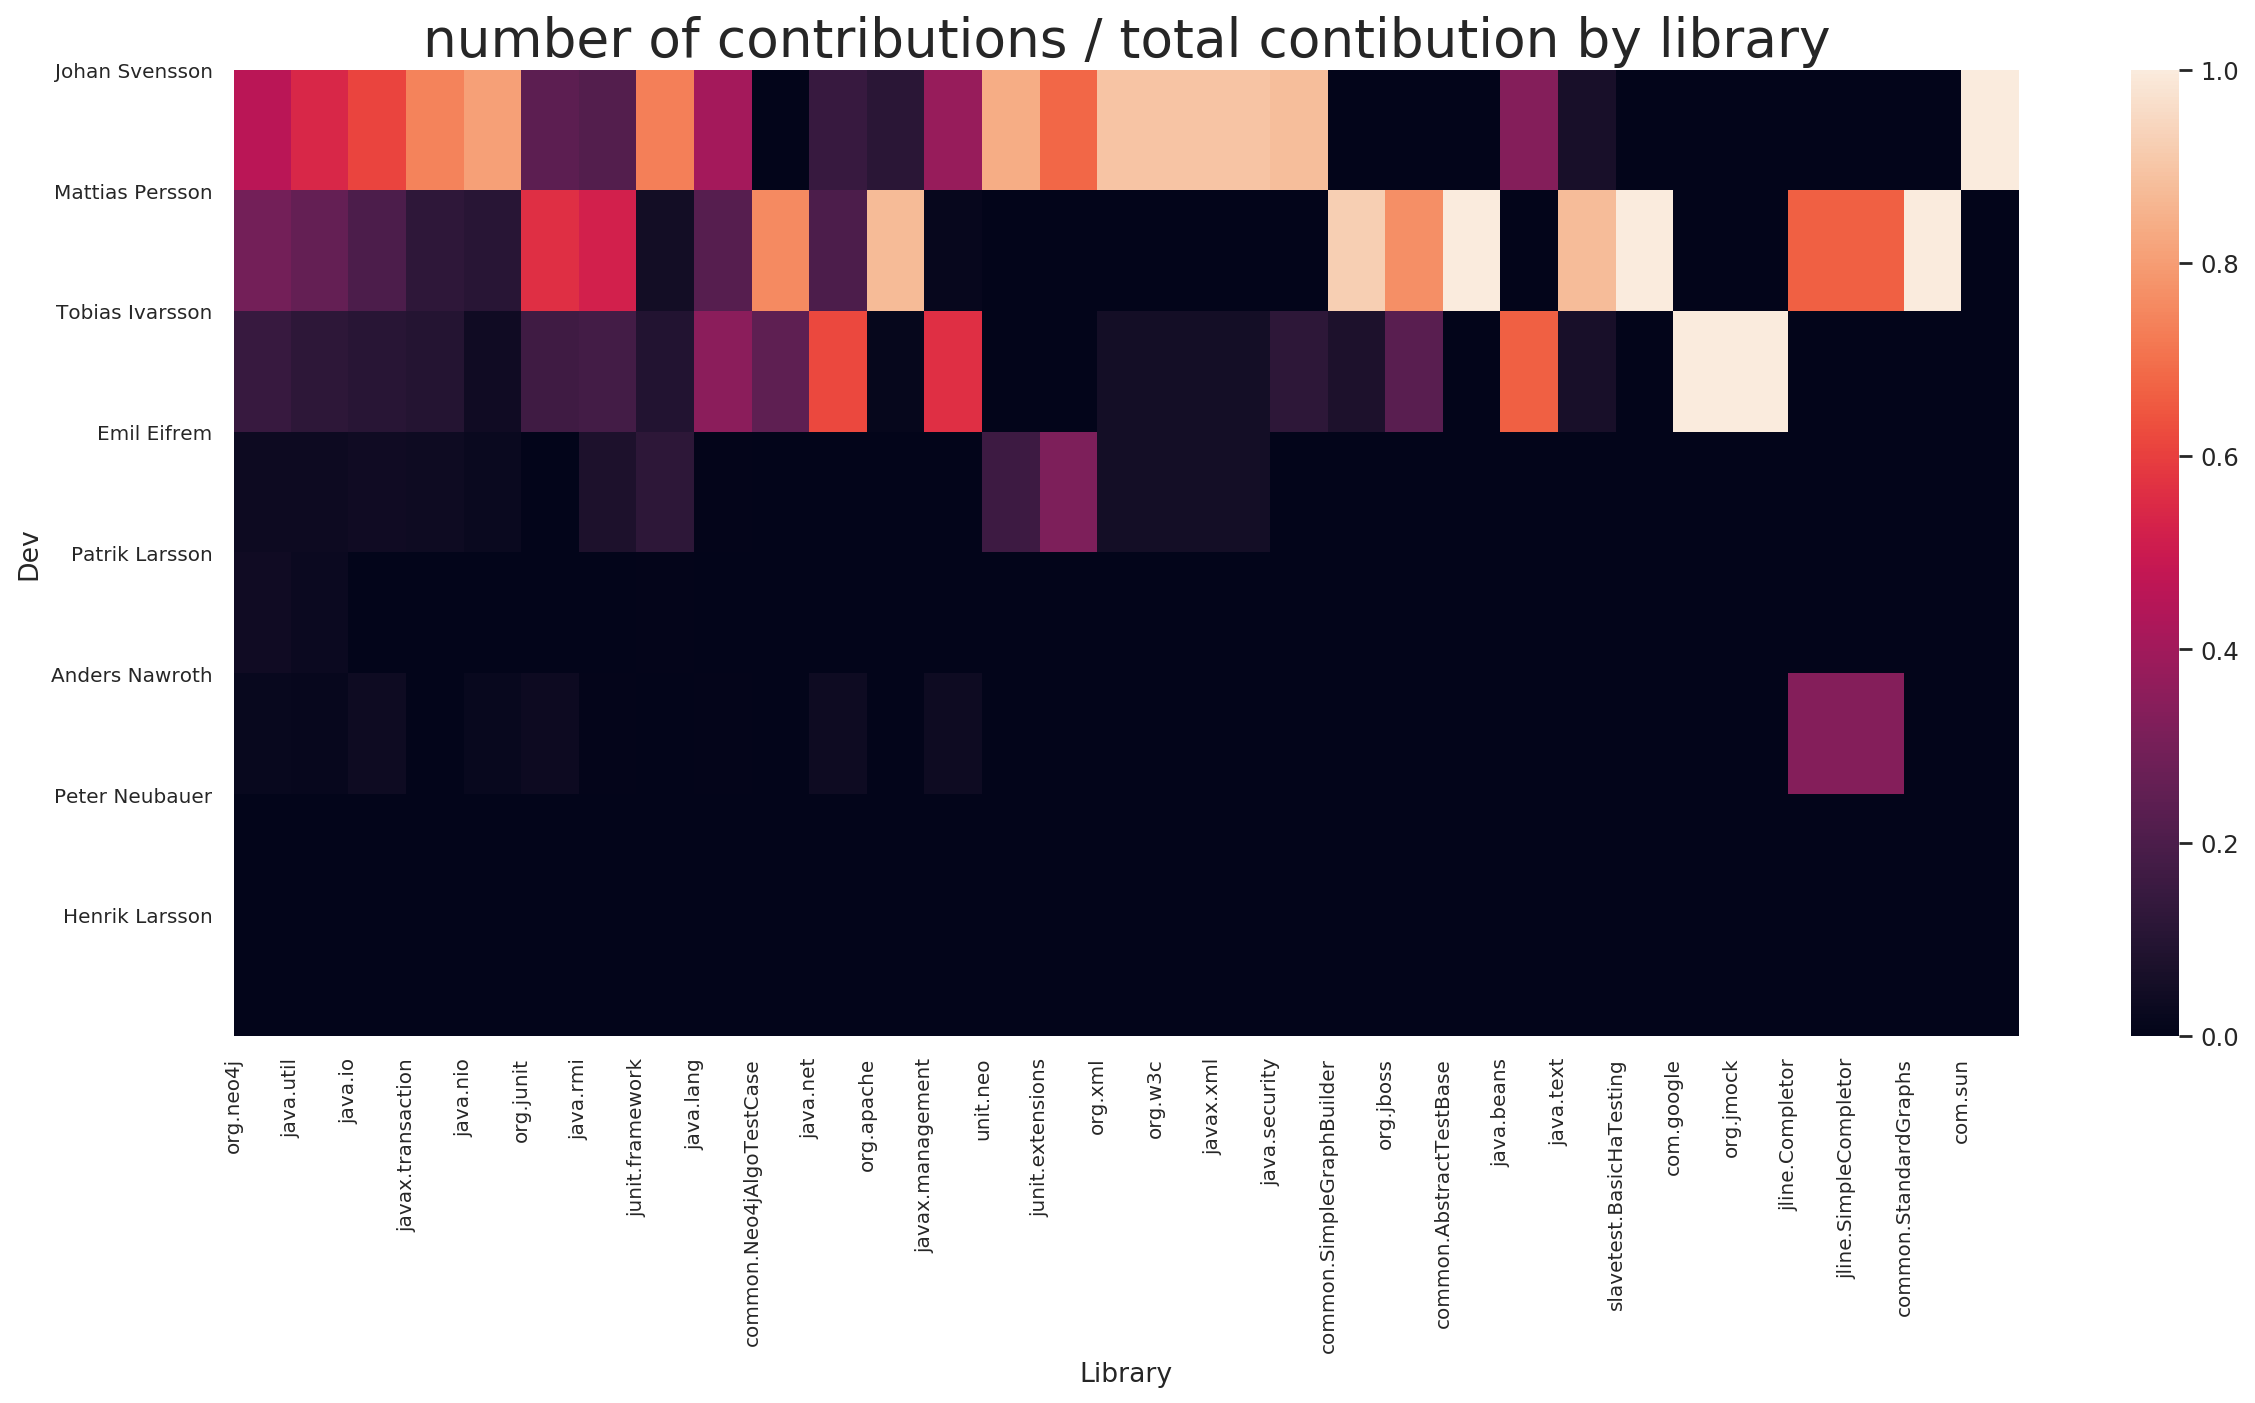

In [28]:
plot_matrix(agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1), 'number of contributions / total contibution by library', xlabel='Library', ylabel='Dev')
plt.show()

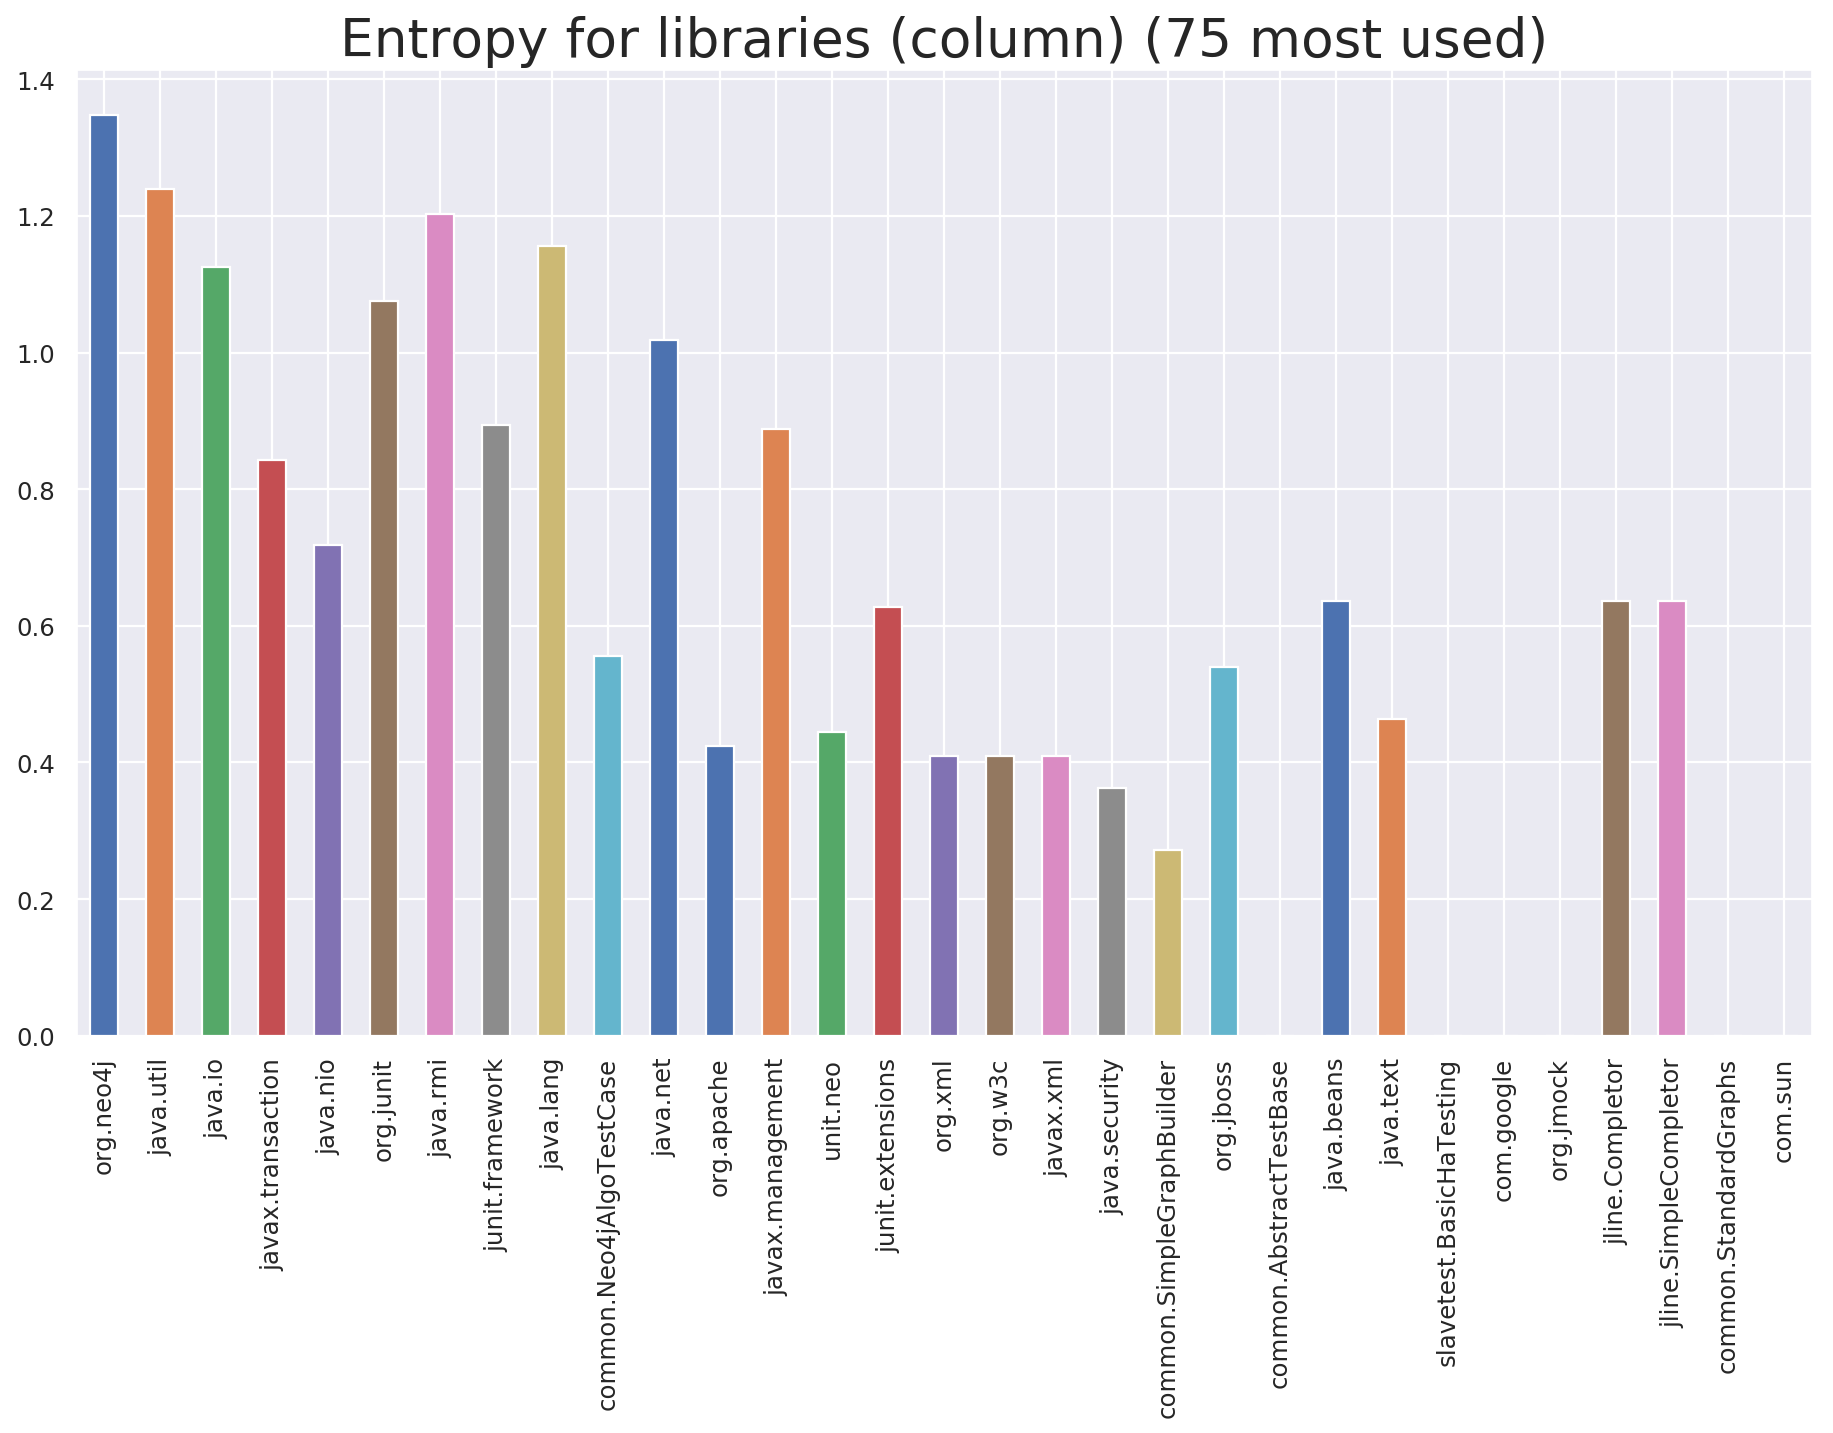

In [29]:
from scipy.stats import entropy

fig = plt.figure(figsize=(14, 8), dpi=160, facecolor='w', edgecolor='k')
#agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1))), 0).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 0).iloc[:77].plot.bar()
plt.title('Entropy for libraries (column) (75 most used)', fontsize=24)
plt.show()

Some libraries seam to contain more information than others, such as spoon.Launcher, junit.testing, org.xml, spoon.metatmodel, spoon.patttern, java.rmi, spoon.refactoring and spoon.eclipse.

Mostly it is spoon.* imports or testing import.

spoon.Spoon has been imported by very few users. Infact this must be a former package that has disappeared since then.

In [30]:
#agreg_sorted['spoon.Spoon'].sort_values(ascending=False).head()

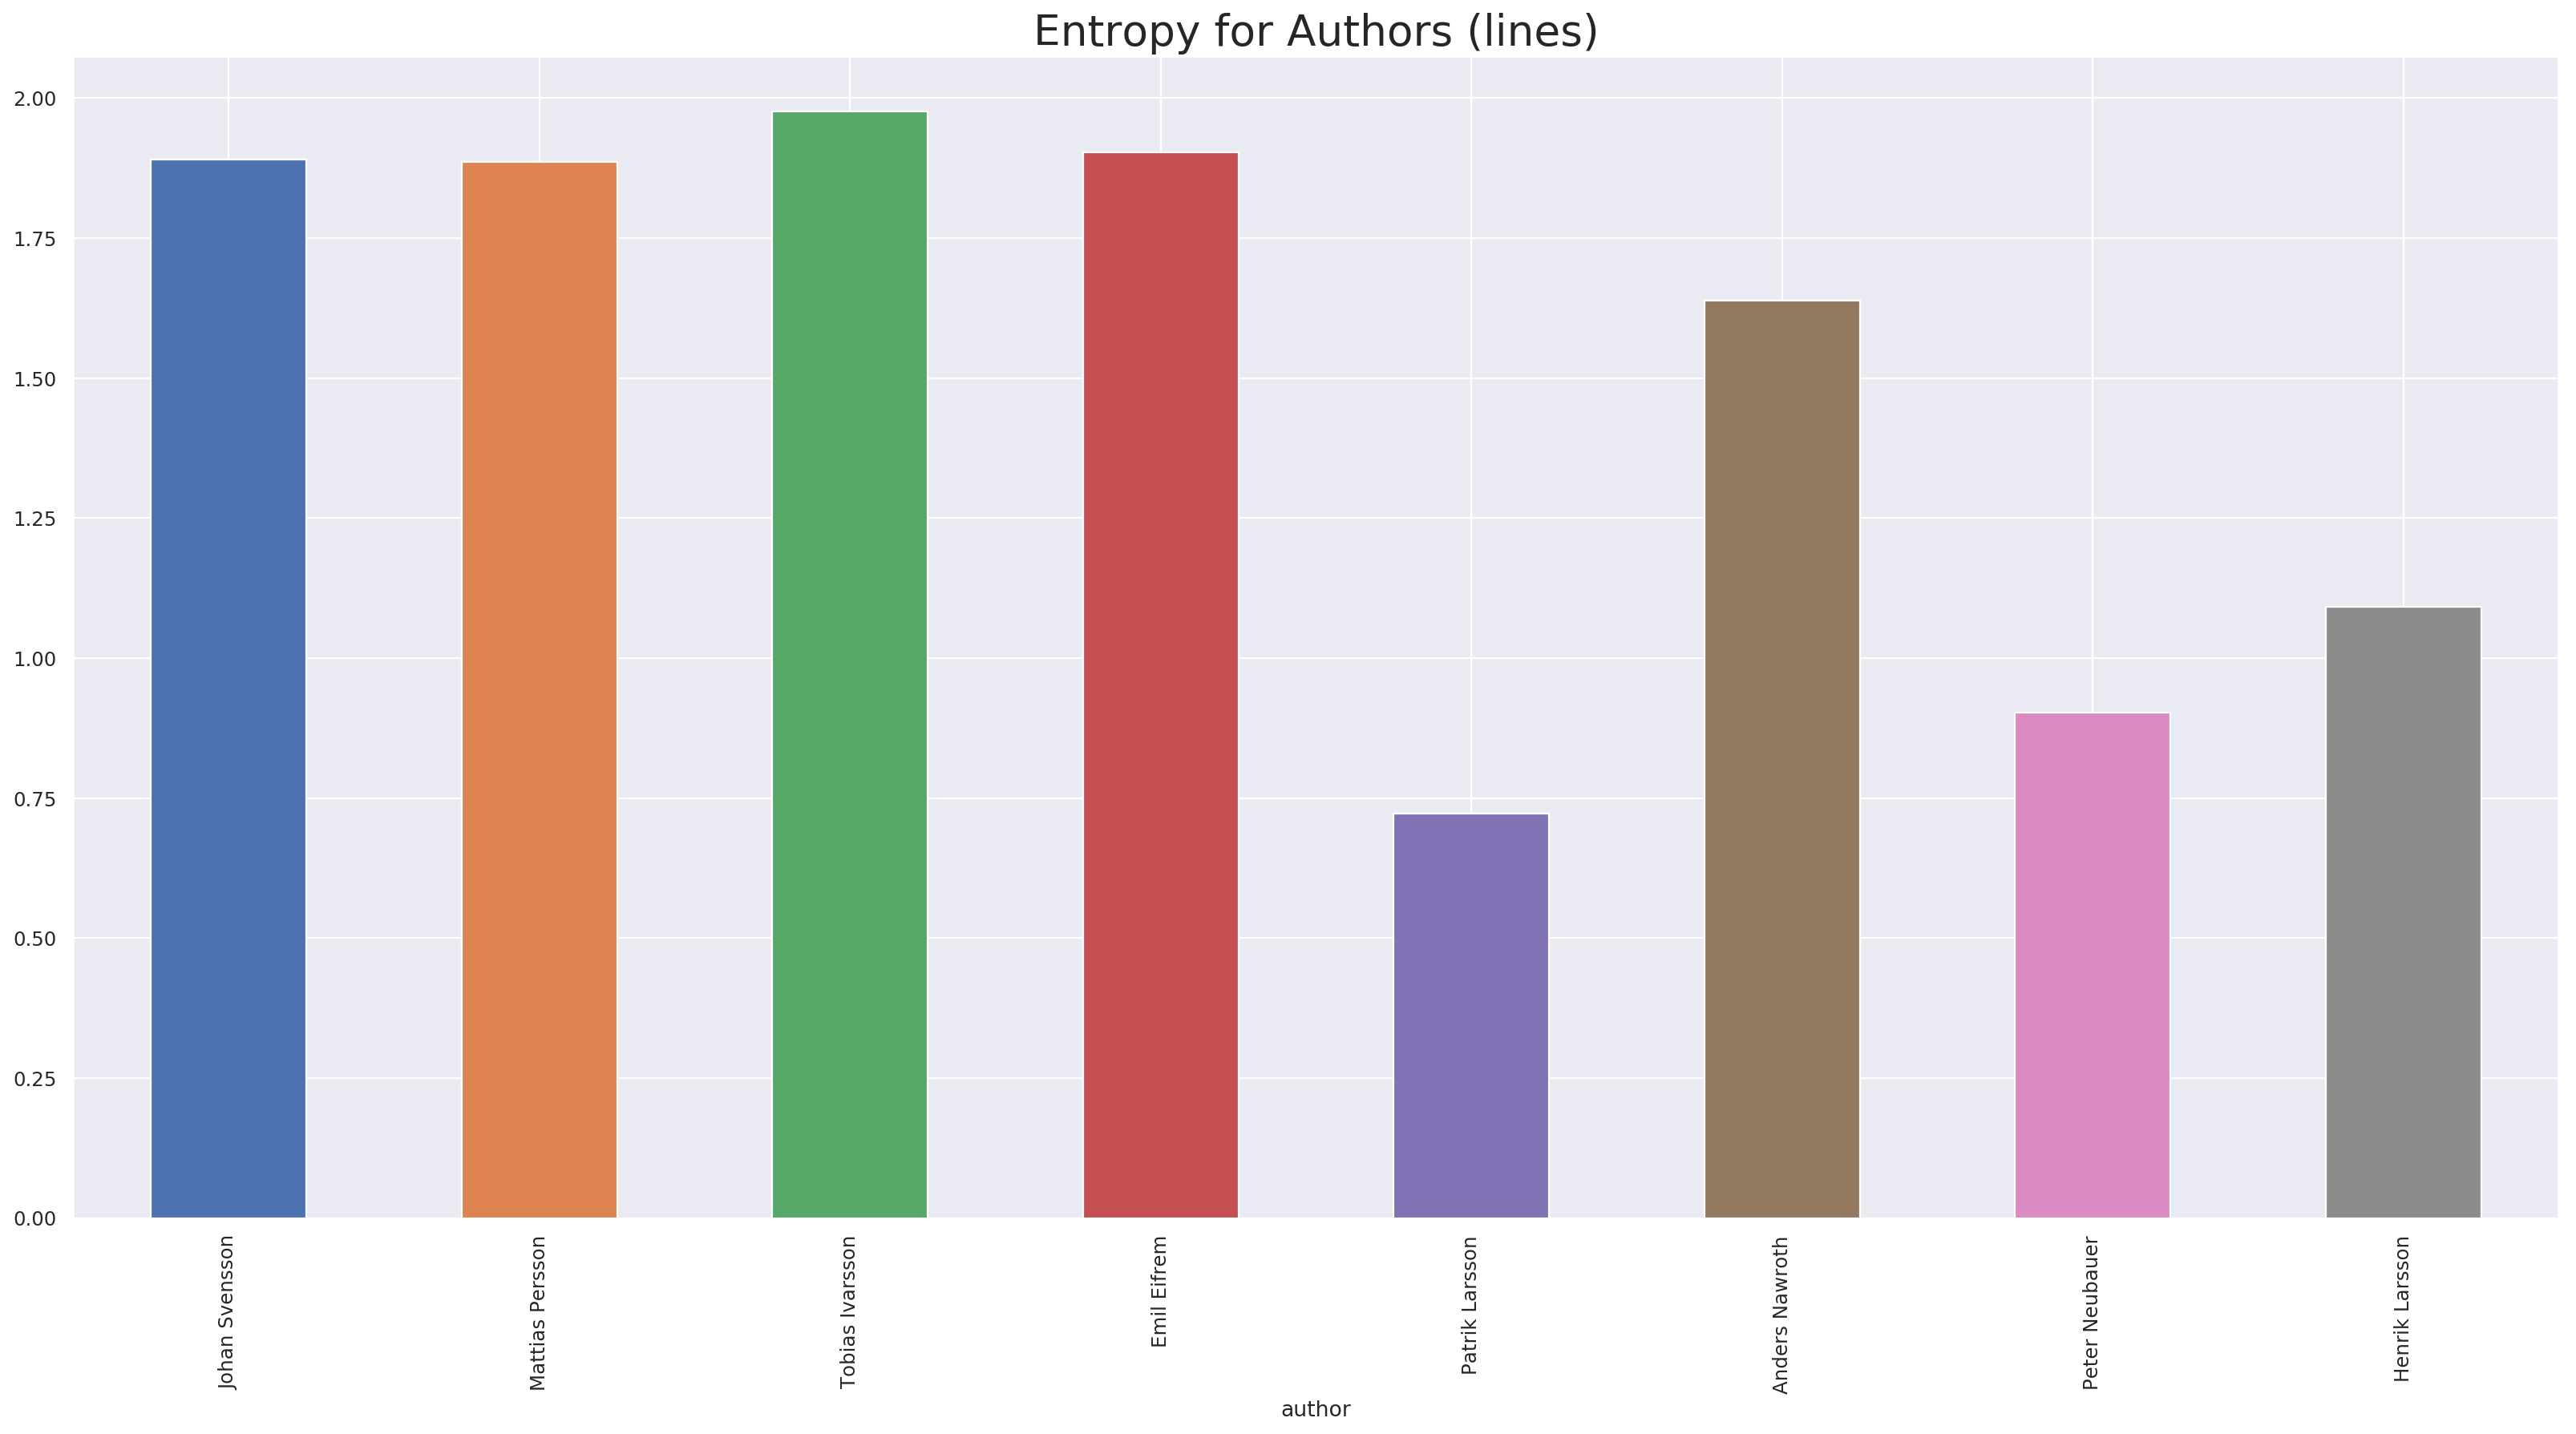

In [31]:
fig = plt.figure(figsize=(25, 12), dpi=160, facecolor='w', edgecolor='k')
# agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1)))), 1).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).plot.bar()
plt.title('Entropy for Authors (lines)', fontsize=24)
plt.show()

Who is renaud and what is spoon.Spoon ? 
And who is Jon ? 

In [32]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

def draw_vector(v0, v1, annotation='', ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='<-',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate(annotation, v0, v1, arrowprops=arrowprops)

def plot_pca(ax, df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None):
    if pc3 != None:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], df.iloc[:,pc3], cmap=cmap, c=c)
    else:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], cmap=cmap, c=c)
        if axis is not None:
            for (index, row) in axis.iterrows():
                draw_vector((0,0), (row.iloc[pc1], row.iloc[pc2]), index, ax=ax)
    if labels:
        for index, line in df.iterrows():
            if pc3 != None:
                ax.text(line.iloc[pc1], line.iloc[pc2], line.iloc[pc3], f'---{index}', fontsize=4)
            else:
                ax.text(line.iloc[pc1], line.iloc[pc2], f'---{index}', fontsize=4)
    ax.set_xlabel(f'PC{pc1+1}')
    ax.set_ylabel(f'PC{pc2+1}')
    if pc3 != None:
        ax.set_zlabel(f'PC{pc3+1}')
    return scatter

def quick_pca_plot(df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None):
    if pc3 != None:
        fig = plt.figure(figsize=(8, 6), dpi=160, constrained_layout=True)
        gs = GridSpec(2, 2, figure=fig)
        ax12 = fig.add_subplot(gs[0, 0])
        ax23 = fig.add_subplot(gs[0, 1])
        ax13 = fig.add_subplot(gs[1, 0])
        ax = fig.add_subplot(gs[1, 1], projection='3d')
        scatter3d = plot_pca(ax, df, pc1, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax12, df, pc1, pc2, labels=labels, c=c, cmap=cmap)
        plot_pca(ax23, df, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax13, df, pc1, pc3, labels=labels, c=c, cmap=cmap)
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        if c is not None:
            fig.colorbar(scatter3d, cax=cbar_ax)
    else:
        fig = plt.figure(figsize=(6, 6), dpi=160, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
        scatter = plot_pca(ax, df, pc1, pc2, labels=labels, c=c, cmap=cmap, axis=axis)
        if c is not None:
            plt.colorbar(scatter)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


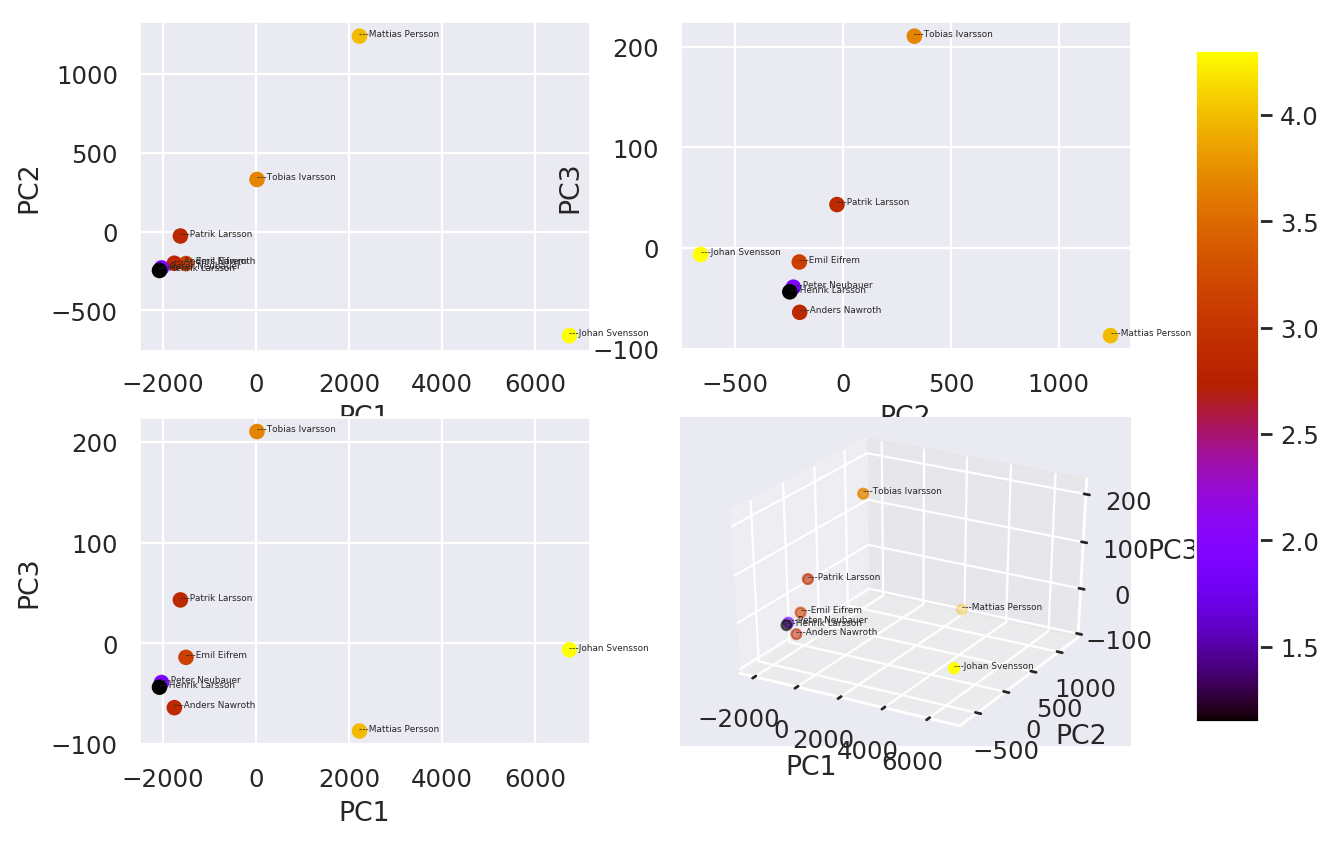

In [33]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(agreg_sorted)

principalDf = pd.DataFrame(data = principalComponents, index = ratio_libcontrib_totcontrib.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#quick_pca_plot(top , 0, 1, 2, labels=True, c=y_kmeans, cmap='Set1')
quick_pca_plot(principalDf, 0, 1, pc3=2, labels=True, c=np.log10(number_of_contibs))
save_fig('pca_raw_data')
plt.show()

### Nomalisation L2

Gaol : Remove the effect of size 

Downsides : tends to delete the effect of small libraries

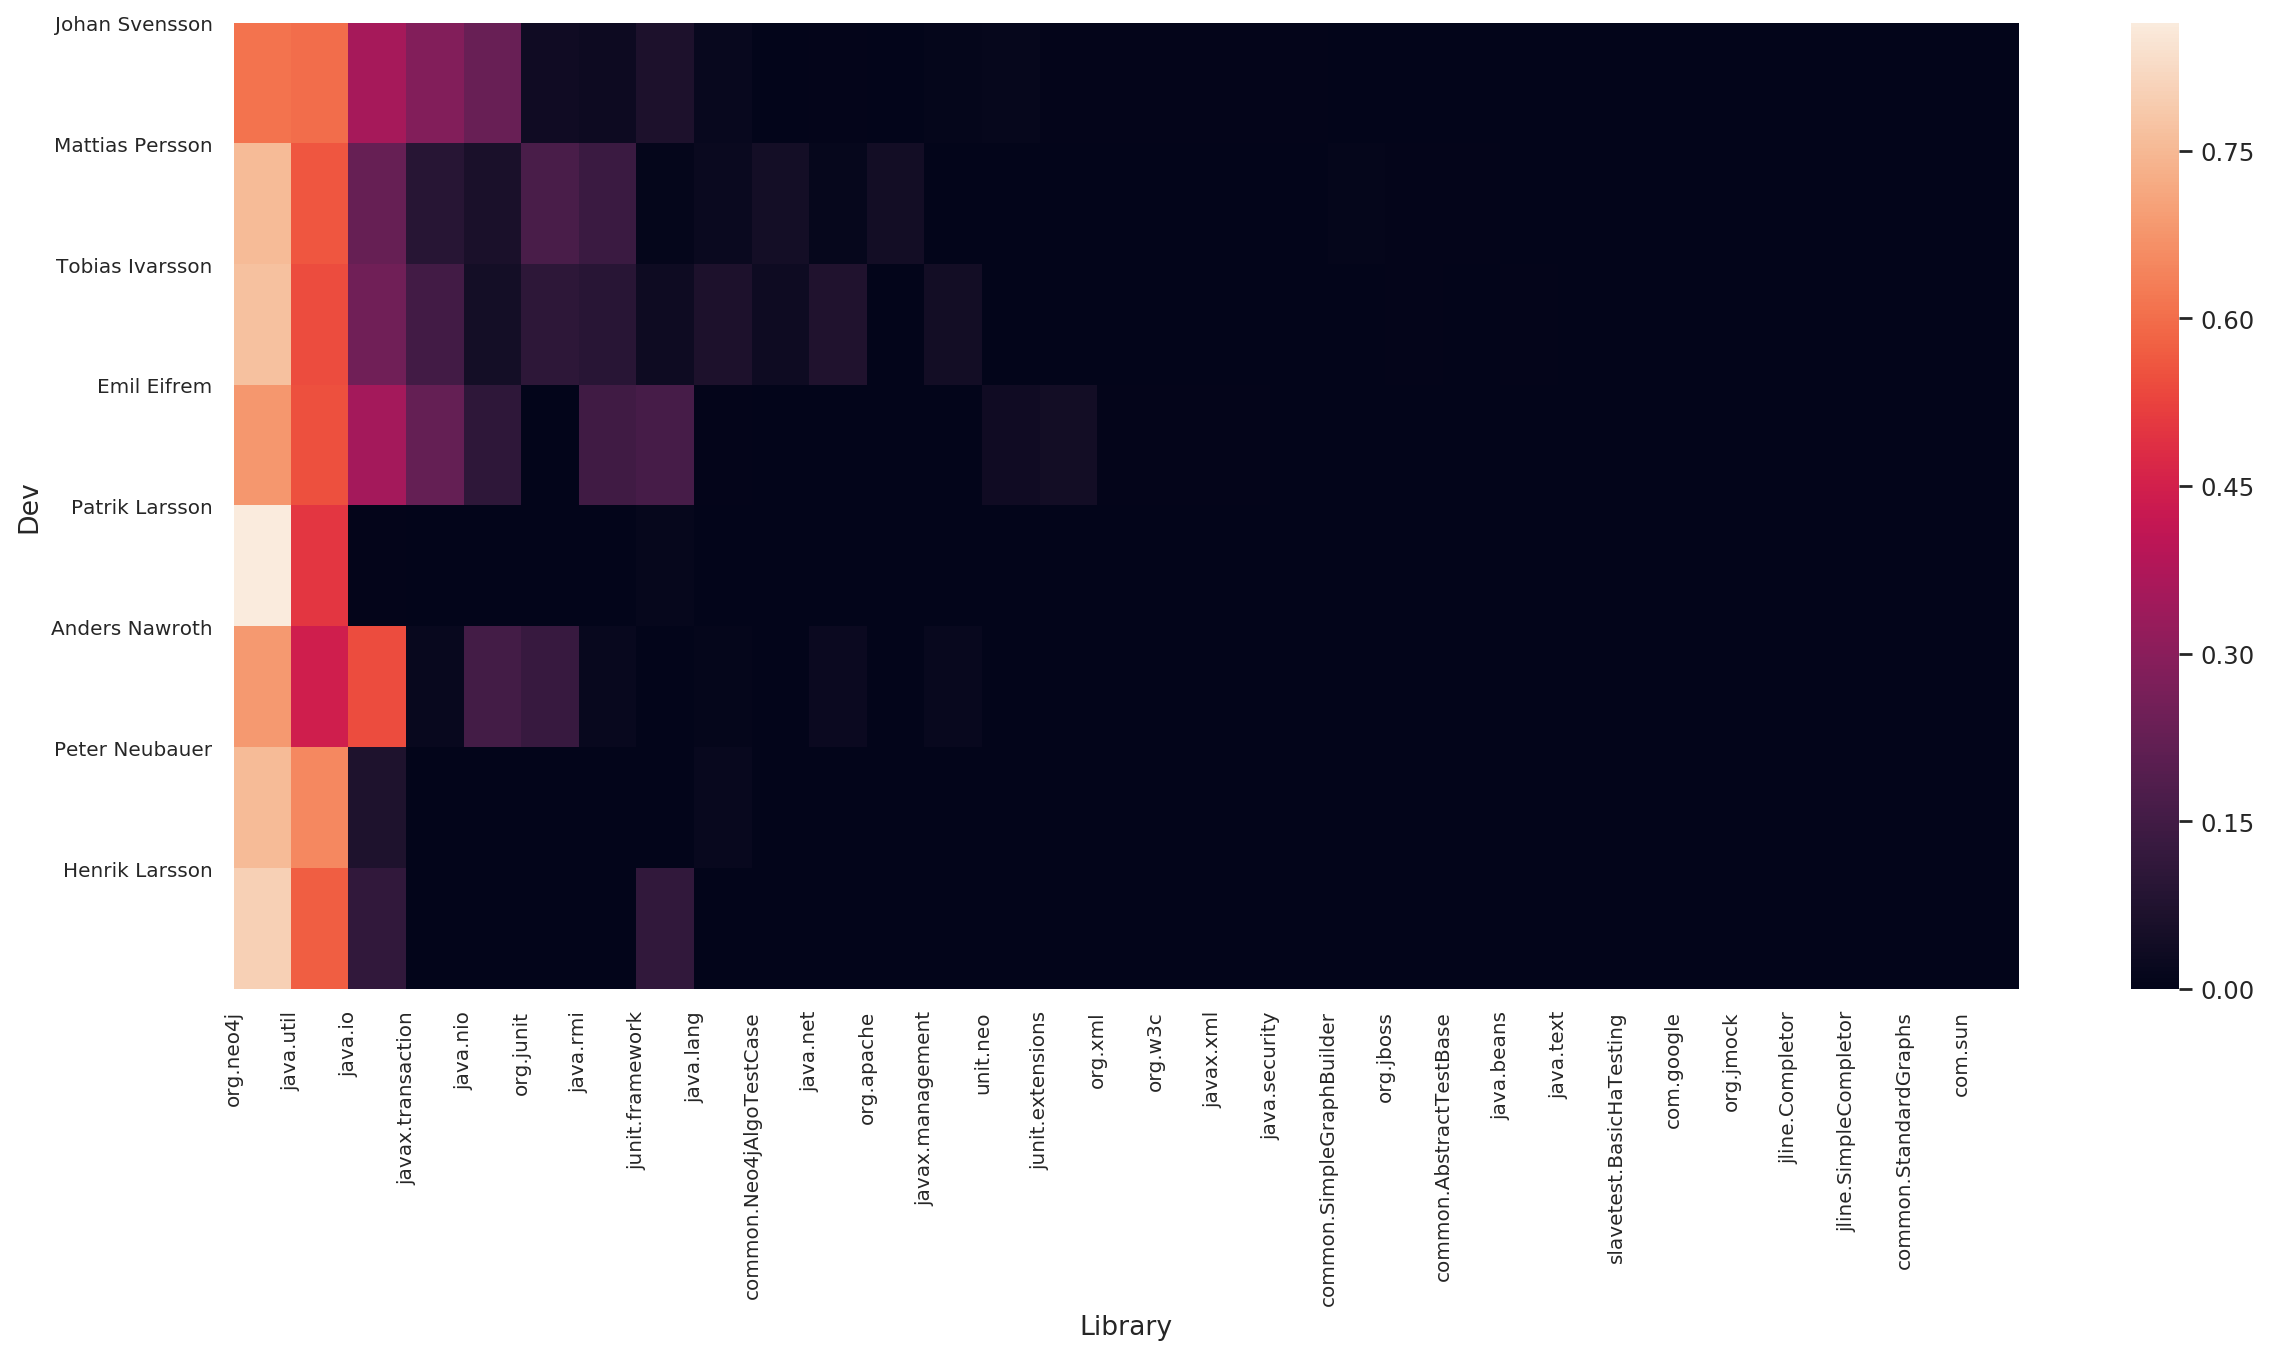

In [34]:
agreg_normalized = agreg_sorted.div(np.sqrt(agreg_sorted.pow(2).sum(axis=1)), axis=0)
plot_matrix(agreg_normalized, '', xlabel='Library', ylabel='Dev')
save_fig('author_lib_L2')
plt.show()

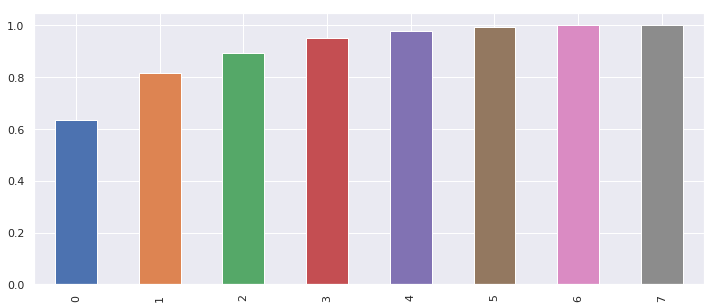

0.814691857456


In [35]:
pca = PCA()

principalComponents = pca.fit_transform(agreg_normalized)

plt.figure(figsize=(12,5))
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot.bar()
plt.show()
print(np.sum(pca.explained_variance_ratio_[:2]))

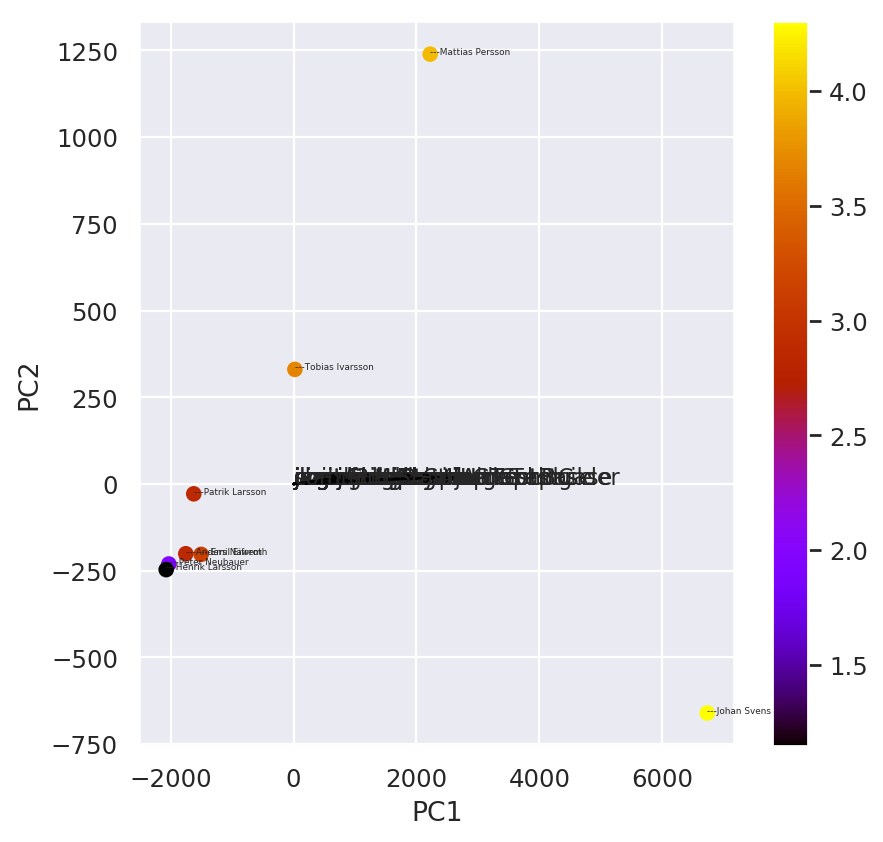

In [36]:
axis_transform = pca.transform(np.diag([1]*len(agreg_normalized.columns)))
axis_transform_df = pd.DataFrame(data = axis_transform[:,:2], index = agreg_normalized.columns
             , columns = ['principal component 1', 'principal component 2'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log10(number_of_contibs), axis=axis_transform_df)
plt.show()

axis_transform_df_top = axis_transform_df[np.sqrt(axis_transform_df.pow(2).sum(axis=1)) > 0.35]


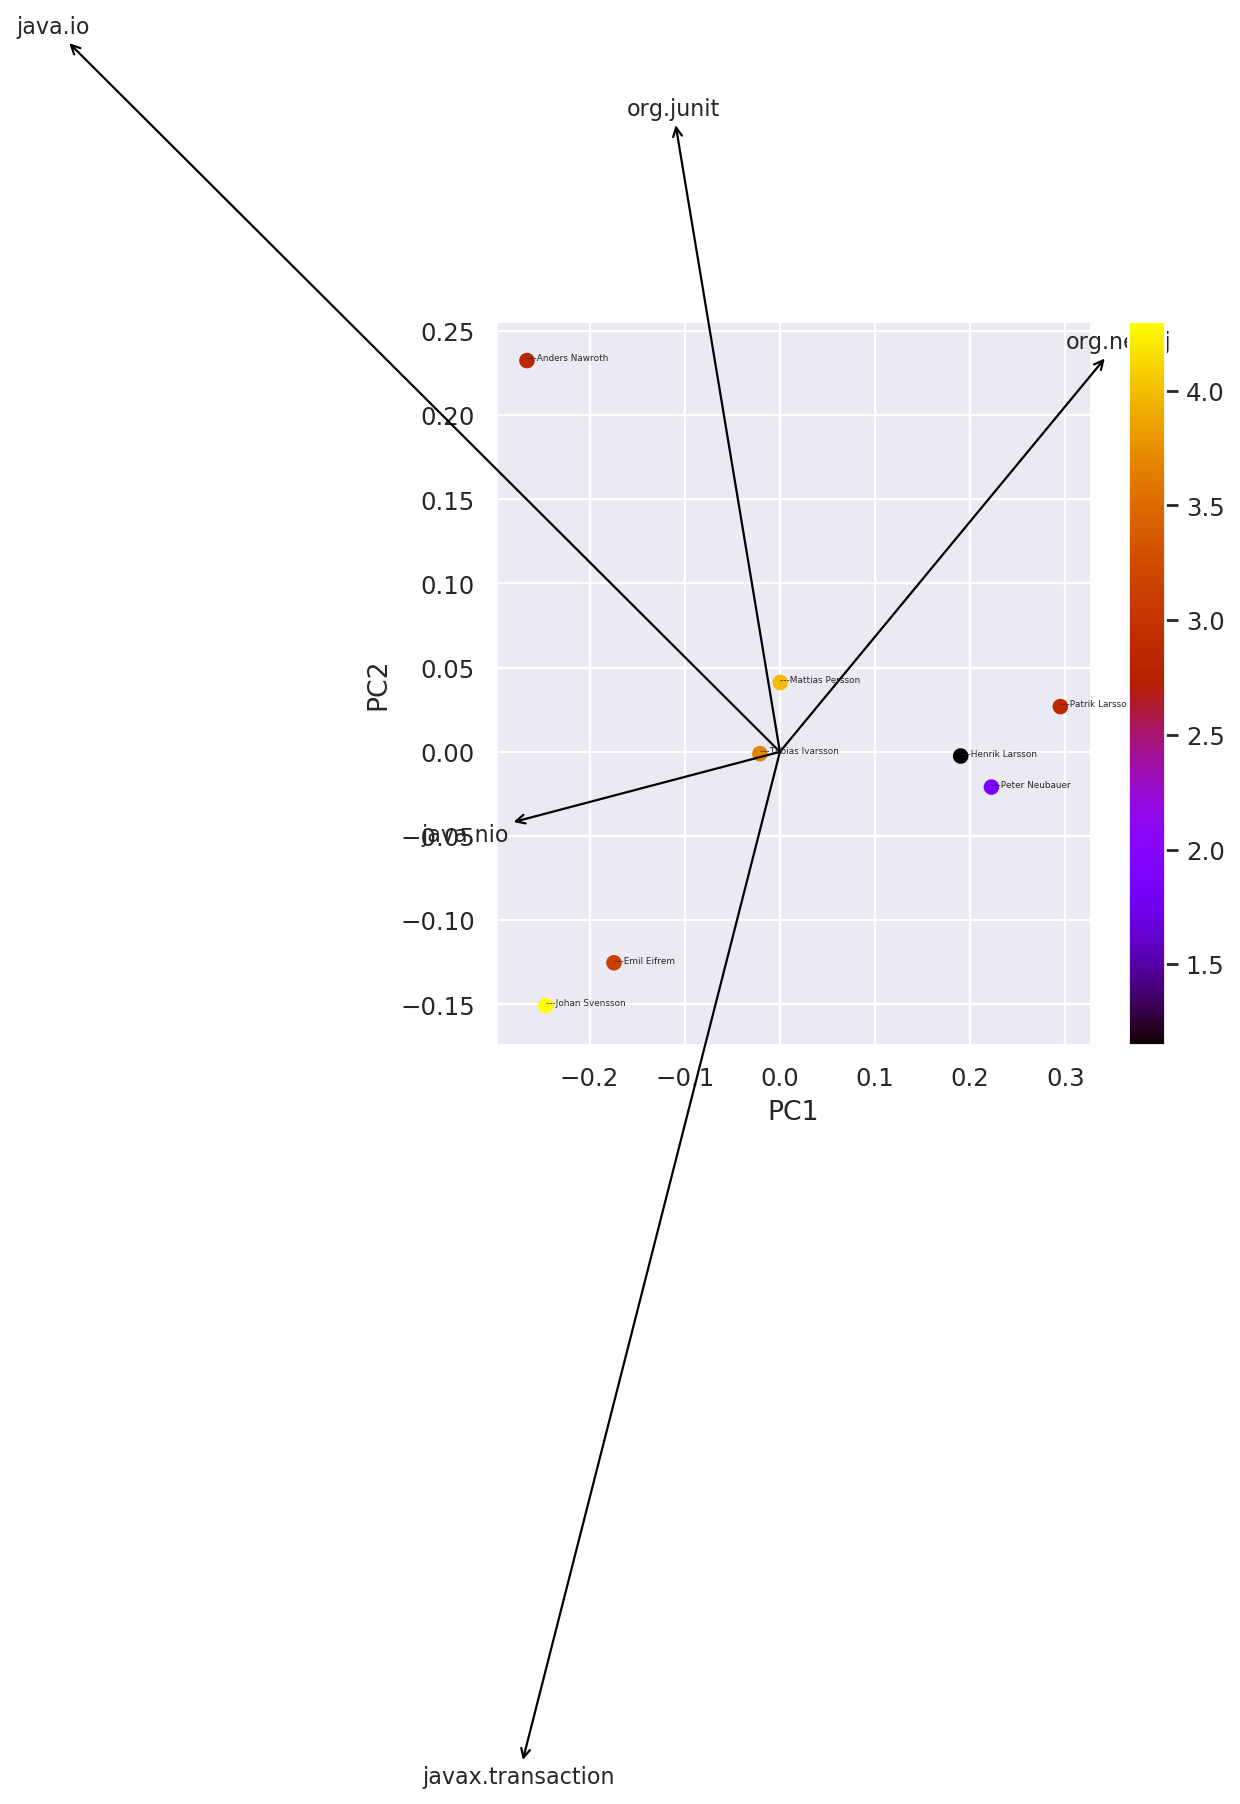

In [37]:
principalDf = pd.DataFrame(data = principalComponents[:,:3], index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log10(number_of_contibs), axis=axis_transform_df_top)
plt.show()

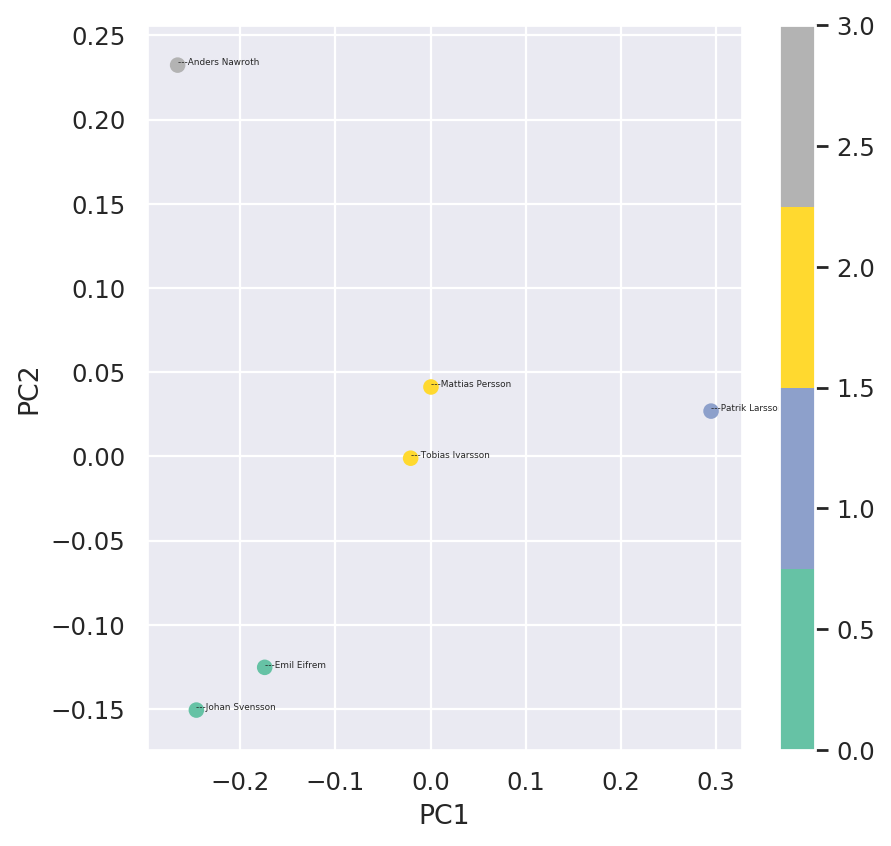

In [38]:
from sklearn.cluster import KMeans # or GaussianMixture ? 


top = principalDf.loc[number_of_contibs > 100]
top_agreg = agreg_normalized.loc[number_of_contibs > 100]

n_clusters = 4
colors = plt.cm.get_cmap('Set2', n_clusters)

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)

y_kmeans = kmeans.predict(top_agreg)

quick_pca_plot(top , 0, 1, labels=True, c=y_kmeans, cmap=colors)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


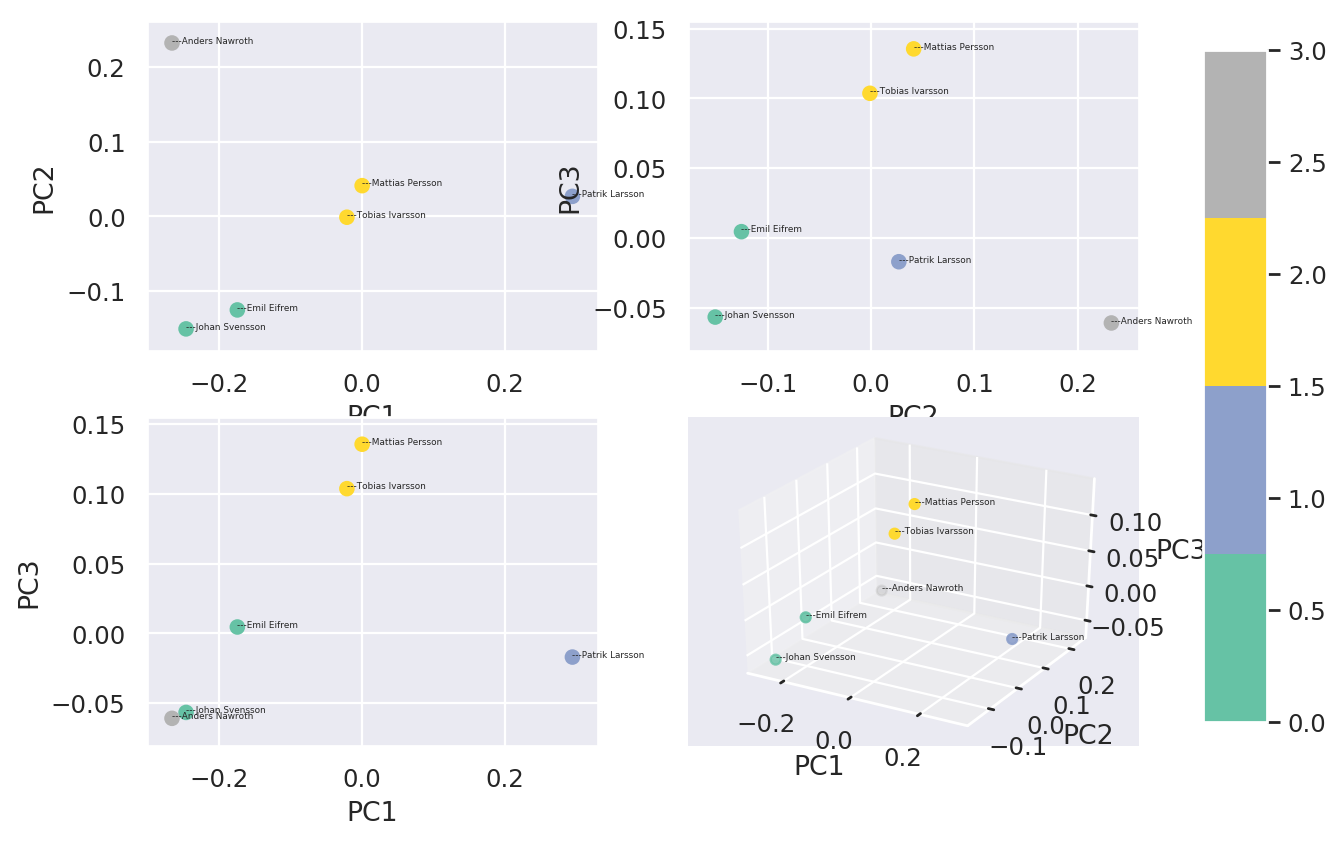

In [39]:
quick_pca_plot(top , 0, 1, 2, labels=True, c=y_kmeans, cmap=colors)
plt.show()

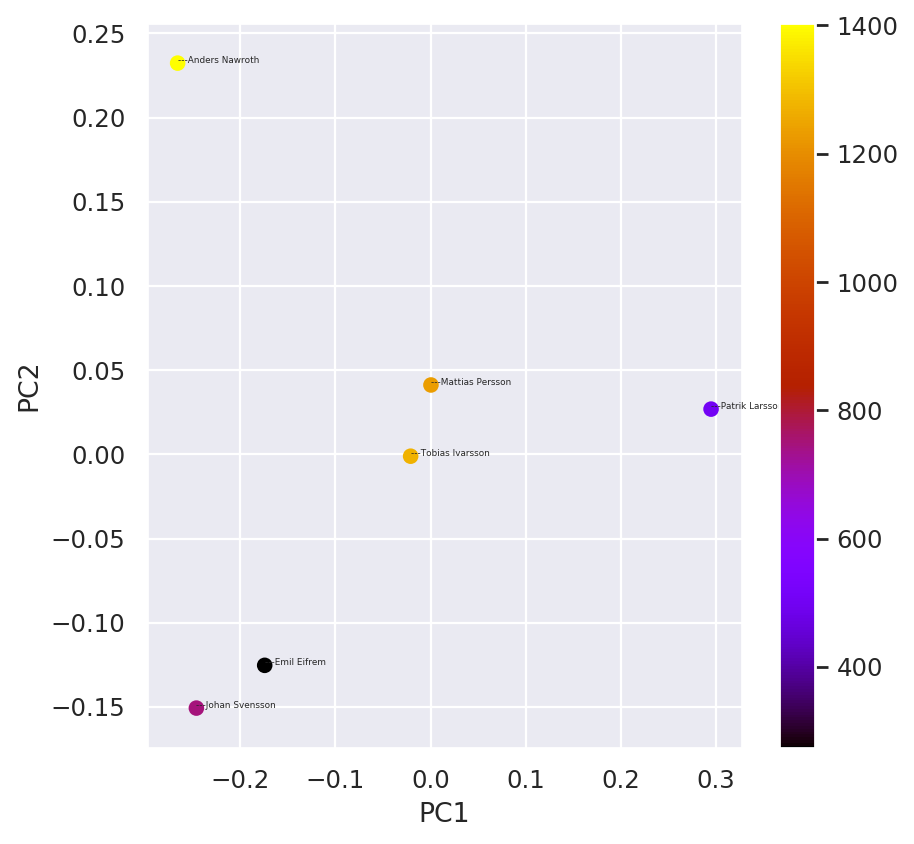

In [40]:
top_avg_contib = avg_contrib.loc[top.index, 'index'].loc[:,'mean']

quick_pca_plot(top , 0, 1, labels=True, c=top_avg_contib)

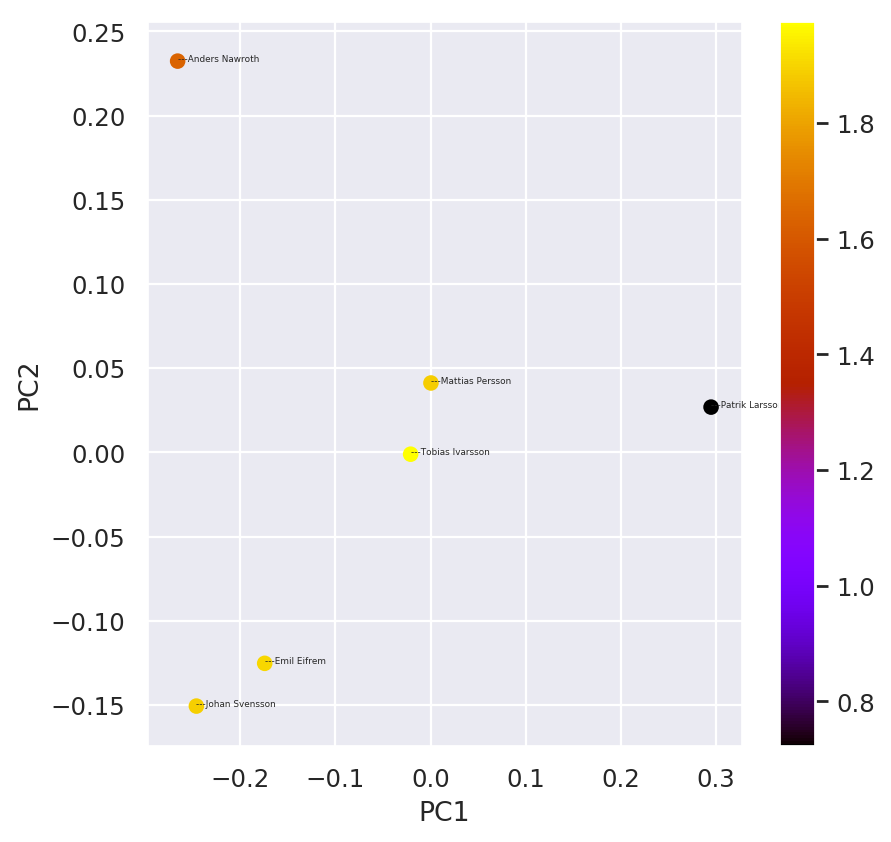

In [41]:
quick_pca_plot(top, 0, 1, labels=True, c=agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).loc[top.index])
plt.show()

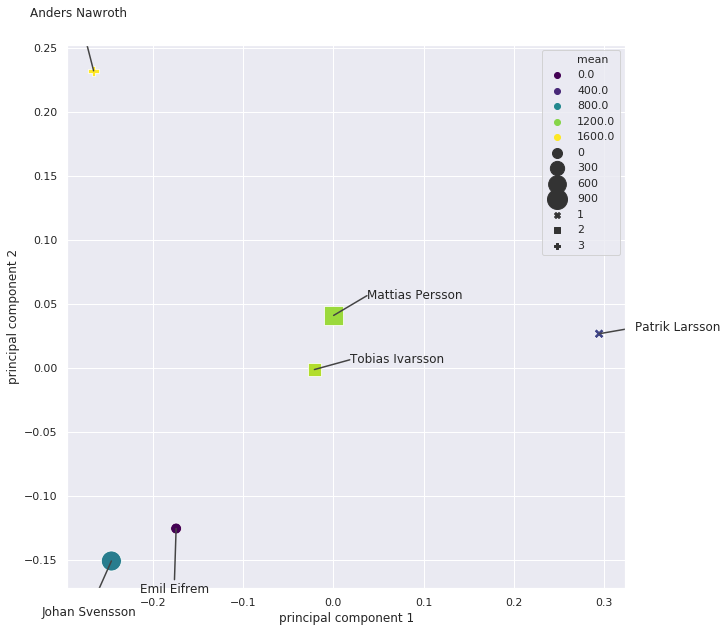

In [42]:
plt.figure(figsize=(10,10))
data = {
    'pc1': top['principal component 1'],
    'pc2': top['principal component 2'],
    'avg_contib': top_avg_contib,
    'cluster': y_kmeans,
    'Number of commits': avg_contrib.loc[top.index, 'index'].loc[:,'count'].values
}
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = sns.scatterplot(x='pc1',y='pc2', data = data, hue = 'avg_contib', palette='viridis', style='cluster', size='Number of commits', sizes=(100, 400))
center_x = -0.17
center_y = -0.03
for index, line in top.iterrows():
    pos_x = line.loc['principal component 1']
    pos_y = line.loc['principal component 2']
    norm = np.sqrt((pos_x-center_x)**2 + (pos_y-center_y)**2)
    offset_x = (pos_x-center_x)/norm * 0.04
    offset_y = (pos_y-center_y)/norm * 0.04
    offset_text_x = (pos_x-center_x)/norm * 0.0475
    offset_text_y = (pos_y-center_y)/norm * 0.0475
    horizontalalignment = 'center'
    if abs(offset_y/offset_x) < 0.5:
        horizontalalignment = 'right' if offset_x<0 else 'left'
        offset_text_y = offset_y
        offset_text_x = offset_x
    text_value = f'{index}'
    l = mlines.Line2D([pos_x,pos_x+offset_x], [pos_y,pos_y + offset_y], color='#444444')
    scatter.add_line(l)
    t = scatter.text(pos_x + offset_text_x, pos_y + offset_text_y, text_value, fontsize=12, va='center',horizontalalignment=horizontalalignment)
save_fig('PCA_all')
plt.show()

Time seems to have an influence on the results. Clearly, the red cluster at the bottom left represent the oldest contributors (who are no longer active). On the other hand, we can see that the black cluster (top right) are the recent contributors. 

I see two major explanations : 
- Trends during the development of the software (the team will focus on certain parts of the project over the years)
- The packages used in the project change over time

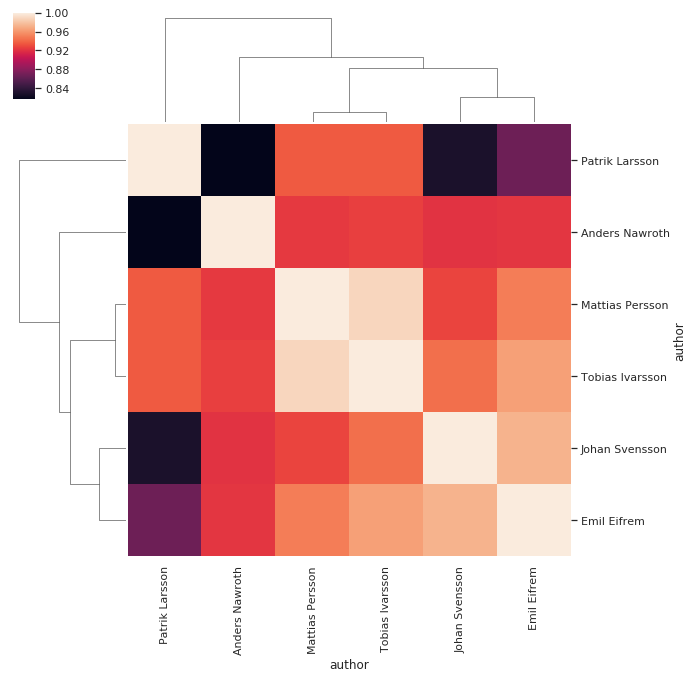

In [43]:
agreg_product = pd.DataFrame(np.matrix(top_agreg) * np.transpose(np.matrix(top_agreg)))
agreg_product.index = top_agreg.index
agreg_product.columns = top_agreg.index

sns.clustermap(agreg_product)
save_fig('similarity_clustermap')
plt.plot();

In [44]:
libraries_distance.shape

(31, 31)

Index(['Johan Svensson', 'Emil Eifrem', 'Patrik Larsson', 'Mattias Persson',
       'Tobias Ivarsson', 'Anders Nawroth'],
      dtype='object', name='author')


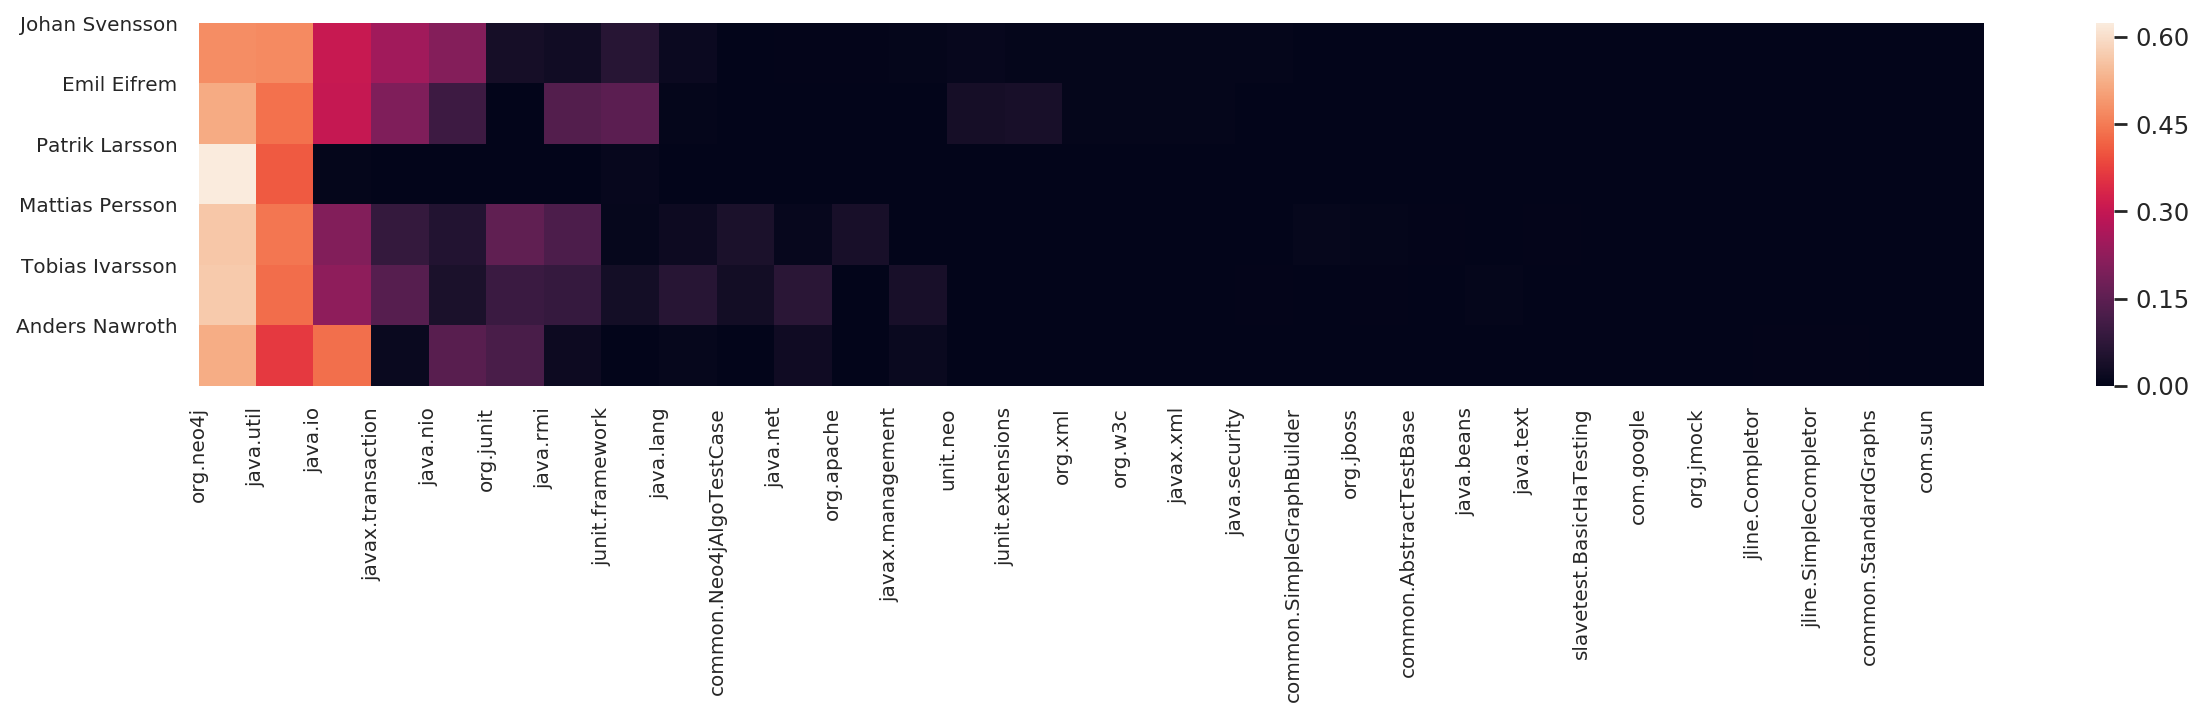

In [45]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)
y_kmeans = kmeans.predict(top_agreg)
index_cluster = np.array(kmeans.labels_).argsort()

plot_matrix(np.log(1+top_agreg.iloc[index_cluster]), title='', figsize=(18,3))
print(top_agreg.iloc[index_cluster].index)

Let's try to give more weight to small packages by changing the normalization used.

### t-SNE

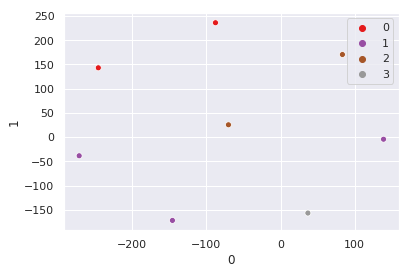

In [46]:
from sklearn.manifold import TSNE

top_agreg_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(agreg_normalized))
top_agreg_embedded.index = agreg_normalized.index

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(agreg_normalized)

y_kmeans = kmeans.predict(agreg_normalized)

sns.scatterplot(top_agreg_embedded.iloc[:,0],top_agreg_embedded.iloc[:,1], hue=y_kmeans, palette="Set1")

### Oublie exponetielle

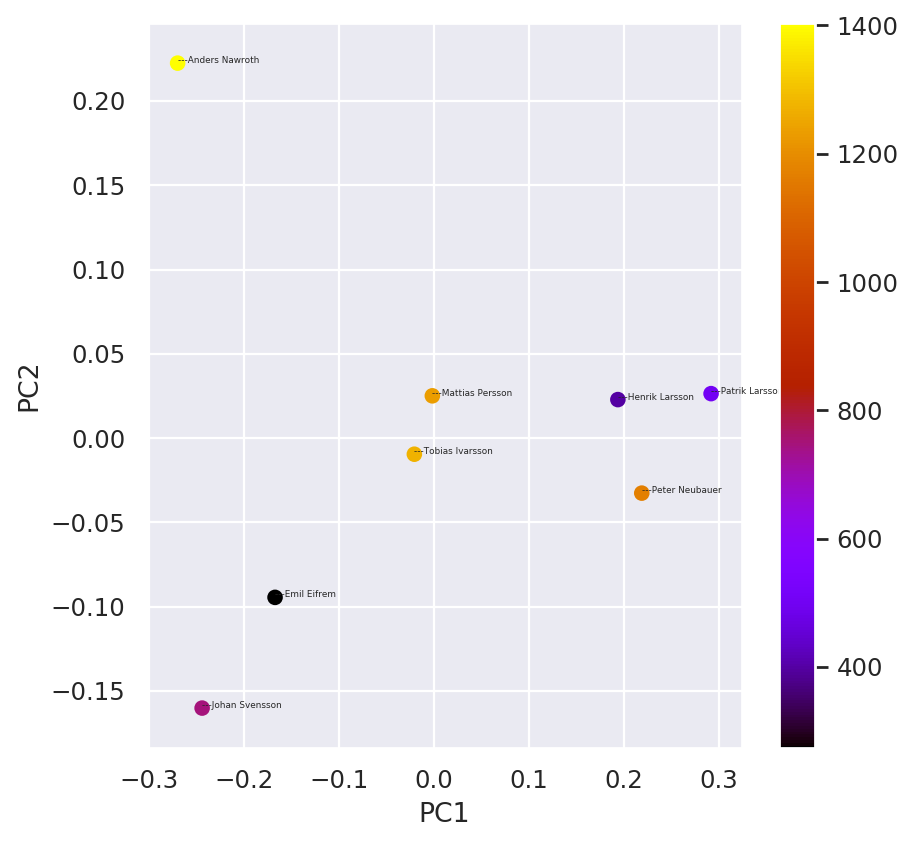

In [47]:
agreg_sorted_lib_extinction = agreg_sorted.mul(libraries_info.loc[agreg_sorted.columns, 'coef'])
agreg_sorted_lib_extinction_L2  = agreg_sorted_lib_extinction.div(np.sqrt(agreg_sorted_lib_extinction.pow(2).sum(axis=1)), axis=0)

pca = PCA(n_components=2).fit_transform(agreg_sorted_lib_extinction_L2)

principalDf = pd.DataFrame(data = pca, index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=avg_contrib.loc[principalDf.index, 'index'].loc[:,'mean'])
plt.show()

### CoClust

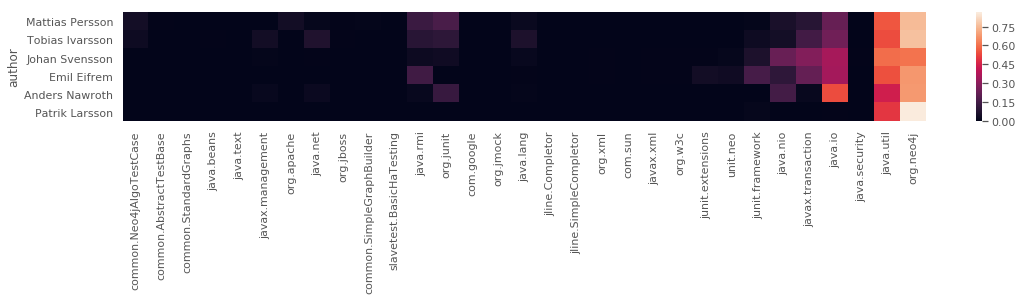

In [48]:
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.visualization import plot_reorganized_matrix

model = CoclustMod(n_clusters = 3, n_init = 20)
model.fit(np.matrix(top_agreg))
fit_data = top_agreg.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

plt.figure(figsize=(18,2))
sns.heatmap(fit_data)